# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель:** разработать модель машинного обучения, которая по техническим характеристикам и комплектации автомобиля сможет точно и быстро предсказывать его рыночную стоимость.

**Задачи:**
1. Ознакомиться и подготовить данные.
2. Подготовить выборки и обучить модели.
3. Проанализировать модели и выбрать лучшую.

# Описание данных

Данные находятся в файле `/datasets/autos.csv`

**Признаки**

* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

## Подготовка данных

Загрузим данные.

In [1]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

In [2]:
!pip install phik
!pip install category_encoders
!pip install catboost
!pip install lightgbm

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import phik
import lightgbm as lgb
import time

from catboost import CatBoostRegressor
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor

In [4]:
try:
    df = pd.read_csv('/Users/user/Desktop/Курсы/Яндекс/Численные методы/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('display.max_columns', None)

display(df.head(5))

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Структура данных соответсвует описанию.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Датасет содержит 354369 строк и 16 столбцов. Типы данных в большинстве своем соответсвуют, но типы датированных признаков следует откорректировать. Так же названия столбцов подвергнем изменениям - приведем к snake case. 

In [6]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format='%Y-%m-%d')
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format='%Y-%m-%dT%H:%M:%S')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

Типы данных исправлены.

In [8]:
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()
print(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


Реализован snake case.  
Проверим данные на пропуски и дубликаты.

In [9]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 4


Удалим дубликаты.

In [10]:
df = df.drop_duplicates()

In [11]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 0


In [12]:
def check (column):
    """
    Функция выводит:
    - Уникальные значения в столбце
    - Количество уникальных значений
    - Количество пропущенных значений (NaN)
    """
    
    print(f"Уникальные значения: {df[column].unique()}")
    print(f"Количество уникальных значений: {df[column].nunique()}")
    print(f"Количество пропущенных значений: {df[column].isna().sum()}")

In [13]:
check('date_crawled')

Уникальные значения: ['2016-03-24T11:52:17.000000000' '2016-03-24T10:58:45.000000000'
 '2016-03-14T12:52:21.000000000' ... '2016-03-21T09:50:58.000000000'
 '2016-03-14T17:48:27.000000000' '2016-03-19T18:57:12.000000000']
Количество уникальных значений: 271174
Количество пропущенных значений: 0


In [14]:
check('price')

Уникальные значения: [  480 18300  9800 ... 12395 18429 10985]
Количество уникальных значений: 3731
Количество пропущенных значений: 0


In [15]:
check('vehicle_type')

Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений: 8
Количество пропущенных значений: 37490


In [16]:
check('registration_year')

Уникальные значения: [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
Количество уникальных значений: 151
Количество пропущенных значений: 0


Обнаружены аномальные значения, заполним аномальные значения NaN.

In [17]:
df['registration_year'] = df['registration_year'].where(
    (df['registration_year'] >= 1930) & (df['registration_year'] <= 2016),
    np.nan
)

In [18]:
df[df['registration_year'] >= df['date_crawled'].dt.year]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
16,2016-04-01 12:46:46,300,NaN,"2,016.000",NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
31,2016-03-29 16:57:02,899,NaN,"2,016.000",manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,"2,016.000",manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,"2,016.000",NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
52,2016-04-04 10:57:36,1400,NaN,"2,016.000",manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04,0,34454,2016-04-06 12:45:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354107,2016-03-09 12:51:50,395,NaN,"2,016.000",manual,60,golf,150000,12,petrol,volkswagen,NaN,2016-03-09,0,25575,2016-04-05 23:45:21
354115,2016-03-07 11:59:24,299,NaN,"2,016.000",manual,60,astra,150000,4,petrol,opel,yes,2016-03-07,0,49326,2016-03-20 01:46:49
354169,2016-03-29 19:50:03,3000,NaN,"2,016.000",manual,0,colt,150000,8,gasoline,mitsubishi,no,2016-03-29,0,45472,2016-04-06 05:46:43
354198,2016-03-10 23:36:19,1350,NaN,"2,016.000",manual,0,clk,150000,8,NaN,mercedes_benz,yes,2016-03-10,0,26427,2016-03-13 02:45:51


Обнаружено 9499 строк где дата регистрации автомобиля превышает дату выгрузки анкеты.

In [19]:
check('registration_year')

Уникальные значения: [1993. 2011. 2004. 2001. 2008. 1995. 1980. 2014. 1998. 2005.   nan 2016.
 2007. 2009. 2002. 1997. 1990. 1981. 2003. 1994. 1991. 1984. 2006. 1999.
 2012. 2010. 2000. 1992. 2013. 1996. 1985. 1989. 2015. 1982. 1976. 1983.
 1973. 1969. 1971. 1987. 1986. 1988. 1970. 1965. 1945. 1974. 1979. 1955.
 1978. 1972. 1968. 1977. 1961. 1960. 1966. 1975. 1963. 1964. 1954. 1958.
 1967. 1959. 1956. 1941. 1962. 1957. 1940. 1949. 1937. 1951. 1953. 1933.
 1950. 1948. 1952. 1932. 1942. 1935. 1936. 1930. 1944. 1943. 1934. 1938.
 1931. 1947. 1946.]
Количество уникальных значений: 86
Количество пропущенных значений: 14713


In [20]:
check('gearbox')

Уникальные значения: ['manual' 'auto' nan]
Количество уникальных значений: 2
Количество пропущенных значений: 19833


Заполним пропуски на основе среднего значения, сгруппированного по столбцам 'model' и 'brand'.

В столбце power явно есть аномалии данных, связанные с ошибкой ввода. Заменим аномальные значения на nan.

In [21]:
df['power'] = df['power'].where(
    (df['power'] > 50) & (df['power'] < 1000)
    , np.nan
)

check('power')

Уникальные значения: [ nan 190. 163.  75.  69. 102. 109. 125. 101. 105. 140. 115. 131.  60.
 136. 160. 231.  90. 118. 193.  99. 113. 218. 122. 129.  70. 306.  95.
  61. 177.  80. 170.  55. 143.  64. 286. 232. 150. 156.  82. 155.  54.
 185.  87. 180.  86.  84. 224. 235. 200. 178. 265.  77. 110. 144. 120.
 116. 184. 126. 204.  88. 194. 305. 197. 179. 250. 313. 165.  98. 130.
 114. 211.  56. 201. 213.  58. 107.  83. 174. 100. 220.  85.  73. 192.
  68.  66. 299.  74.  52. 147.  65. 310.  71.  97. 239. 203. 300. 103.
 258. 320.  63.  81. 148. 145. 230. 280. 260. 104. 188. 333. 186. 117.
 141.  59. 132. 234. 158.  92.  51. 135.  53. 209. 146.  67. 106. 166.
 276. 344.  72. 249. 237. 245. 111. 326. 279. 138. 175.  96. 226. 301.
 334. 128. 133. 124. 219. 241. 167.  94. 182. 196. 238. 228. 112. 272.
 139. 240.  79. 256. 360. 243. 375. 252. 396. 340. 108. 121. 345. 187.
 289. 222. 198. 284. 450. 233. 387. 152. 347. 172.  57. 137. 212. 476.
 314. 173. 290. 207. 205. 171. 750.  78.  91.  89. 349. 

In [22]:
check('model')

Уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa

In [23]:
check('kilometer')

Уникальные значения: [150000 125000  90000  40000  30000  70000   5000 100000  60000  20000
  80000  50000  10000]
Количество уникальных значений: 13
Количество пропущенных значений: 0


In [24]:
check('registration_month')

Уникальные значения: [ 0  5  8  6  7 10 12 11  2  3  1  4  9]
Количество уникальных значений: 13
Количество пропущенных значений: 0


Заменим значение 0 на. nan.

In [25]:
df['registration_month'] = df['registration_month'].replace(0, np.nan)
check('registration_month')

Уникальные значения: [nan  5.  8.  6.  7. 10. 12. 11.  2.  3.  1.  4.  9.]
Количество уникальных значений: 12
Количество пропущенных значений: 37352


In [26]:
check('fuel_type')

Уникальные значения: ['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']
Количество уникальных значений: 7
Количество пропущенных значений: 32895


In [27]:
check('brand')

Уникальные значения: ['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']
Количество уникальных значений: 40
Количество пропущенных значений: 0


In [28]:
check('repaired')

Уникальные значения: [nan 'yes' 'no']
Количество уникальных значений: 2
Количество пропущенных значений: 71154


In [29]:
check('date_created')

Уникальные значения: ['2016-03-24T00:00:00.000000000' '2016-03-14T00:00:00.000000000'
 '2016-03-17T00:00:00.000000000' '2016-03-31T00:00:00.000000000'
 '2016-04-04T00:00:00.000000000' '2016-04-01T00:00:00.000000000'
 '2016-03-21T00:00:00.000000000' '2016-03-26T00:00:00.000000000'
 '2016-04-07T00:00:00.000000000' '2016-03-15T00:00:00.000000000'
 '2016-03-11T00:00:00.000000000' '2016-03-20T00:00:00.000000000'
 '2016-03-23T00:00:00.000000000' '2016-03-27T00:00:00.000000000'
 '2016-03-12T00:00:00.000000000' '2016-03-13T00:00:00.000000000'
 '2016-03-18T00:00:00.000000000' '2016-03-10T00:00:00.000000000'
 '2016-03-07T00:00:00.000000000' '2016-03-09T00:00:00.000000000'
 '2016-03-08T00:00:00.000000000' '2016-04-03T00:00:00.000000000'
 '2016-03-29T00:00:00.000000000' '2016-03-25T00:00:00.000000000'
 '2016-03-28T00:00:00.000000000' '2016-03-30T00:00:00.000000000'
 '2016-03-22T00:00:00.000000000' '2016-02-09T00:00:00.000000000'
 '2016-03-05T00:00:00.000000000' '2016-04-02T00:00:00.000000000'
 '20

In [30]:
check('number_of_pictures')

Уникальные значения: [0]
Количество уникальных значений: 1
Количество пропущенных значений: 0


Интересный столбец, в дальнейшем его удалим, так как он абсолютно не информативен.

In [31]:
check('postal_code')

Уникальные значения: [70435 66954 90480 ... 38528 38325 31096]
Количество уникальных значений: 8143
Количество пропущенных значений: 0


In [32]:
check('last_seen')

Уникальные значения: ['2016-04-07T03:16:57.000000000' '2016-04-07T01:46:50.000000000'
 '2016-04-05T12:47:46.000000000' ... '2016-03-19T20:44:43.000000000'
 '2016-03-29T10:17:23.000000000' '2016-03-21T10:42:49.000000000']
Количество уникальных значений: 179150
Количество пропущенных значений: 0


Заполним пропуски в важных столбцах - power, gear_box, fuel_type.

In [33]:
mode_gearbox = df.groupby(['model', 'brand'])['gearbox'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.mean()).reset_index(name='gearbox_mode')
mode_fuel_type = df.groupby(['model', 'brand'])['fuel_type'].agg(lambda x: x.mode()[0] if not x.mode().empty else x.mean()).reset_index(name='fuel_type_mode')

mean_power = df.groupby(['model', 'brand'])['power'].agg('mean').reset_index(name='mean_power')

df = df.merge(mode_gearbox, on=['model', 'brand'], how='left')
df = df.merge(mode_fuel_type, on=['model', 'brand'], how='left')
df = df.merge(mean_power, on=['model', 'brand'], how='left')

df['gearbox'] = df['gearbox'].fillna(df['gearbox_mode'])
df['fuel_type'] = df['fuel_type'].fillna(df['fuel_type_mode'])
df['power'] = df['power'].fillna(df['mean_power'])

df = df.drop(columns=['gearbox_mode', 'fuel_type_mode', 'mean_power'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        316875 non-null  object        
 3   registration_year   339652 non-null  float64       
 4   gearbox             350234 non-null  object        
 5   power               346705 non-null  float64       
 6   model               334660 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  317013 non-null  float64       
 9   fuel_type           347202 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            283211 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

Проведем исследовательский анализ данных по целевому признаку.

In [34]:
def categorical_features(attribute, title='', top_n=10):
    """
    Визуализация категориального признака:
    - Гистограмма
    - Круговая диаграмма
    - Boxplot по переменной 'price'

    Параметры:
        attribute: Название категориального признака
        title: Заголовок
        top_n: Сколько категорий отображать
    """
    counts = df[attribute].value_counts().head(top_n)
    filtered_df = df[df[attribute].isin(counts.index)]

    fig, axes = plt.subplots(3, 1, figsize=(12, 16))

    sns.countplot(x=attribute, data=filtered_df, order=counts.index, ax=axes[0], palette='viridis')
    axes[0].set_title(f"{title} — Частоты")
    axes[0].tick_params(axis='x', rotation=90)

    counts.plot.pie(autopct='%1.1f%%', ax=axes[1], cmap='Pastel1')
    axes[1].set_ylabel('')
    axes[1].set_title(f"{title} — Доли")

    sns.boxplot(x=attribute, y='price', data=filtered_df, order=counts.index, ax=axes[2], palette='Set3')
    axes[2].set_title(f"{title} — Цена по категориям")
    axes[2].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

    print(counts)

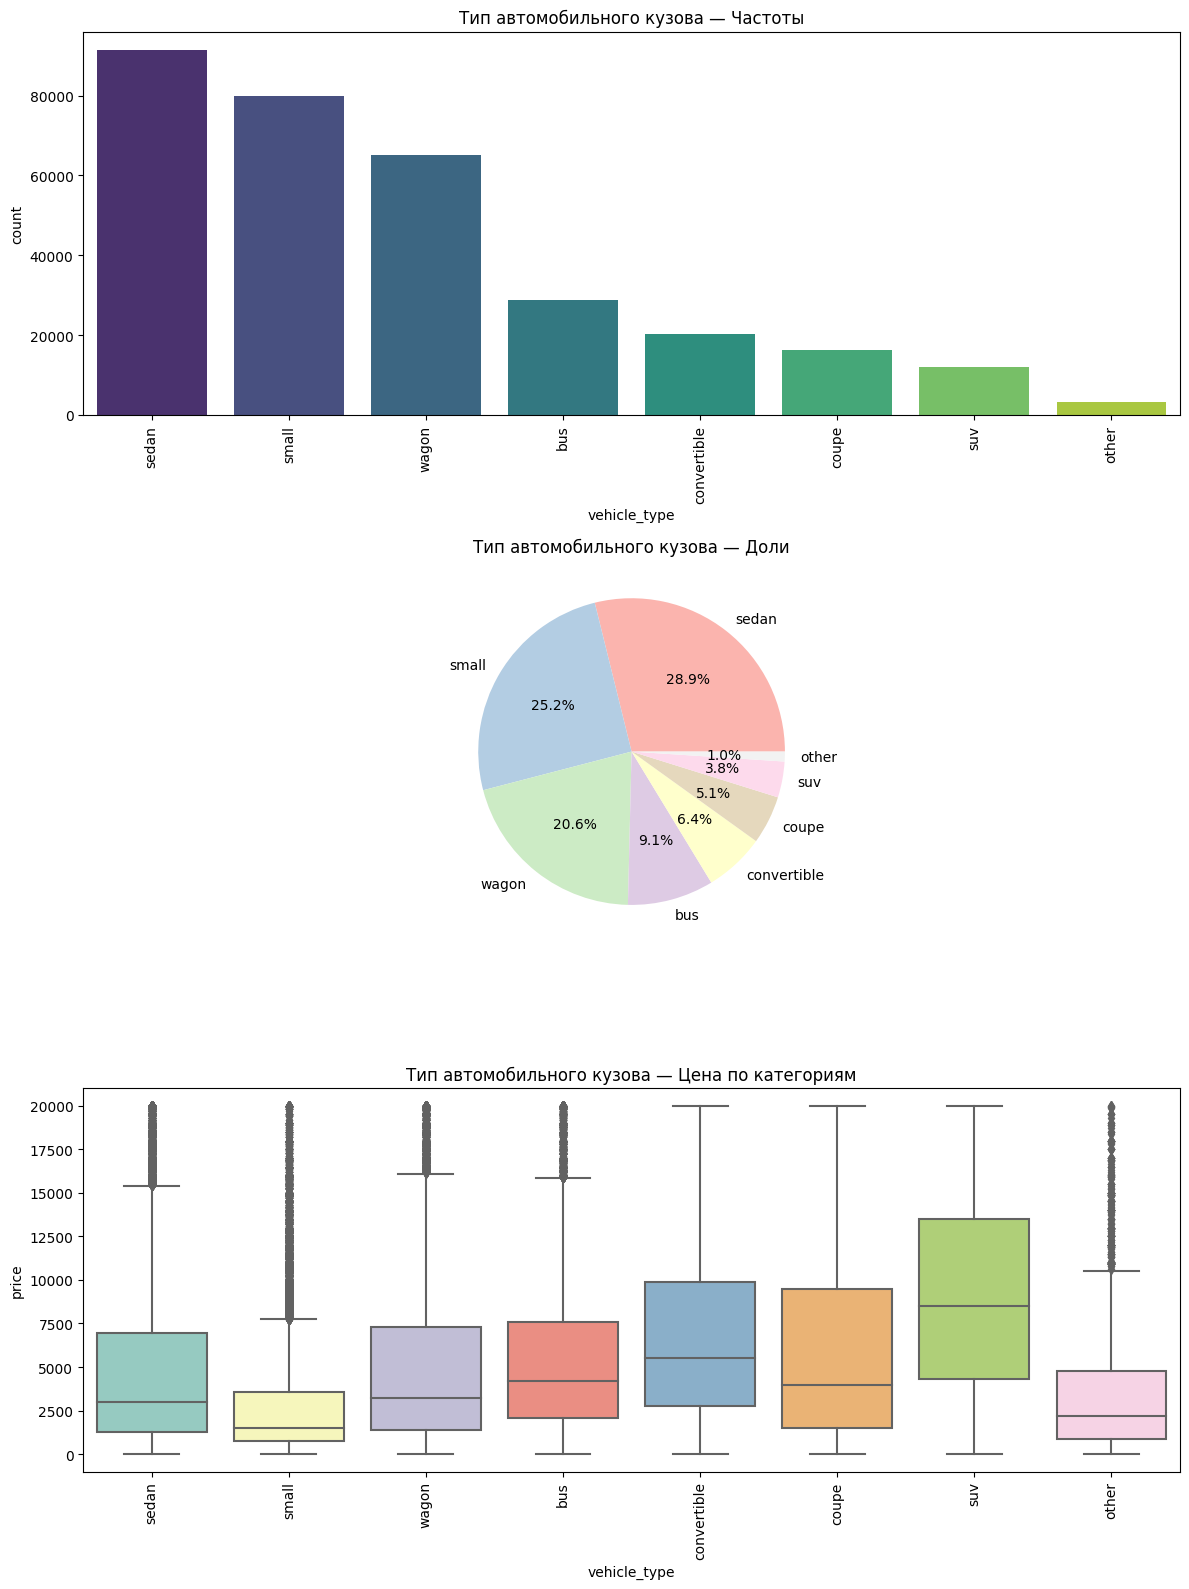

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: vehicle_type, dtype: int64


In [35]:
categorical_features('vehicle_type', 'Тип автомобильного кузова')

Самый распространенный тип кузова - седан, самый редкий тип кузова - сув, он же является самым дорогостоящим. Самый дешевый тип кузова - маленький, он же на втором месте по распространению.

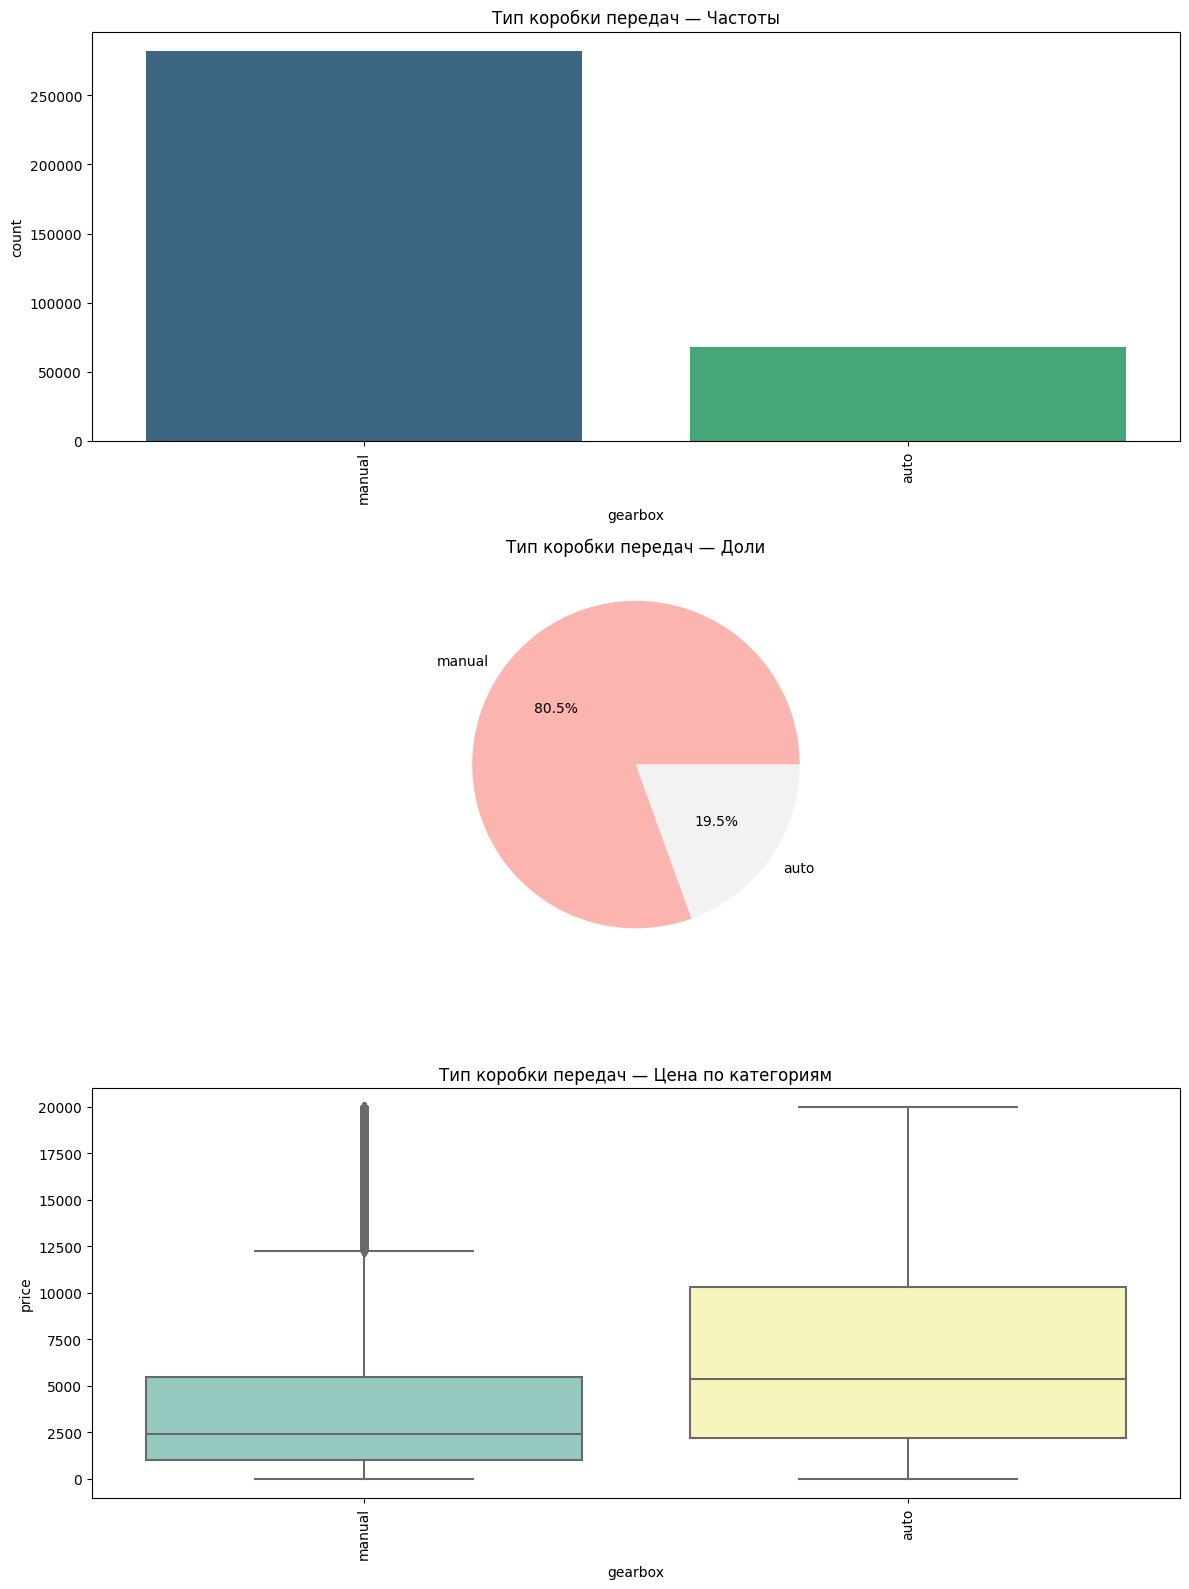

manual    282001
auto       68233
Name: gearbox, dtype: int64


In [36]:
categorical_features('gearbox', 'Тип коробки передач')

80% машин с механической коробкой передач, при этом они стоят почти в два раза дешевле, чем машины с автоматической коробкой.

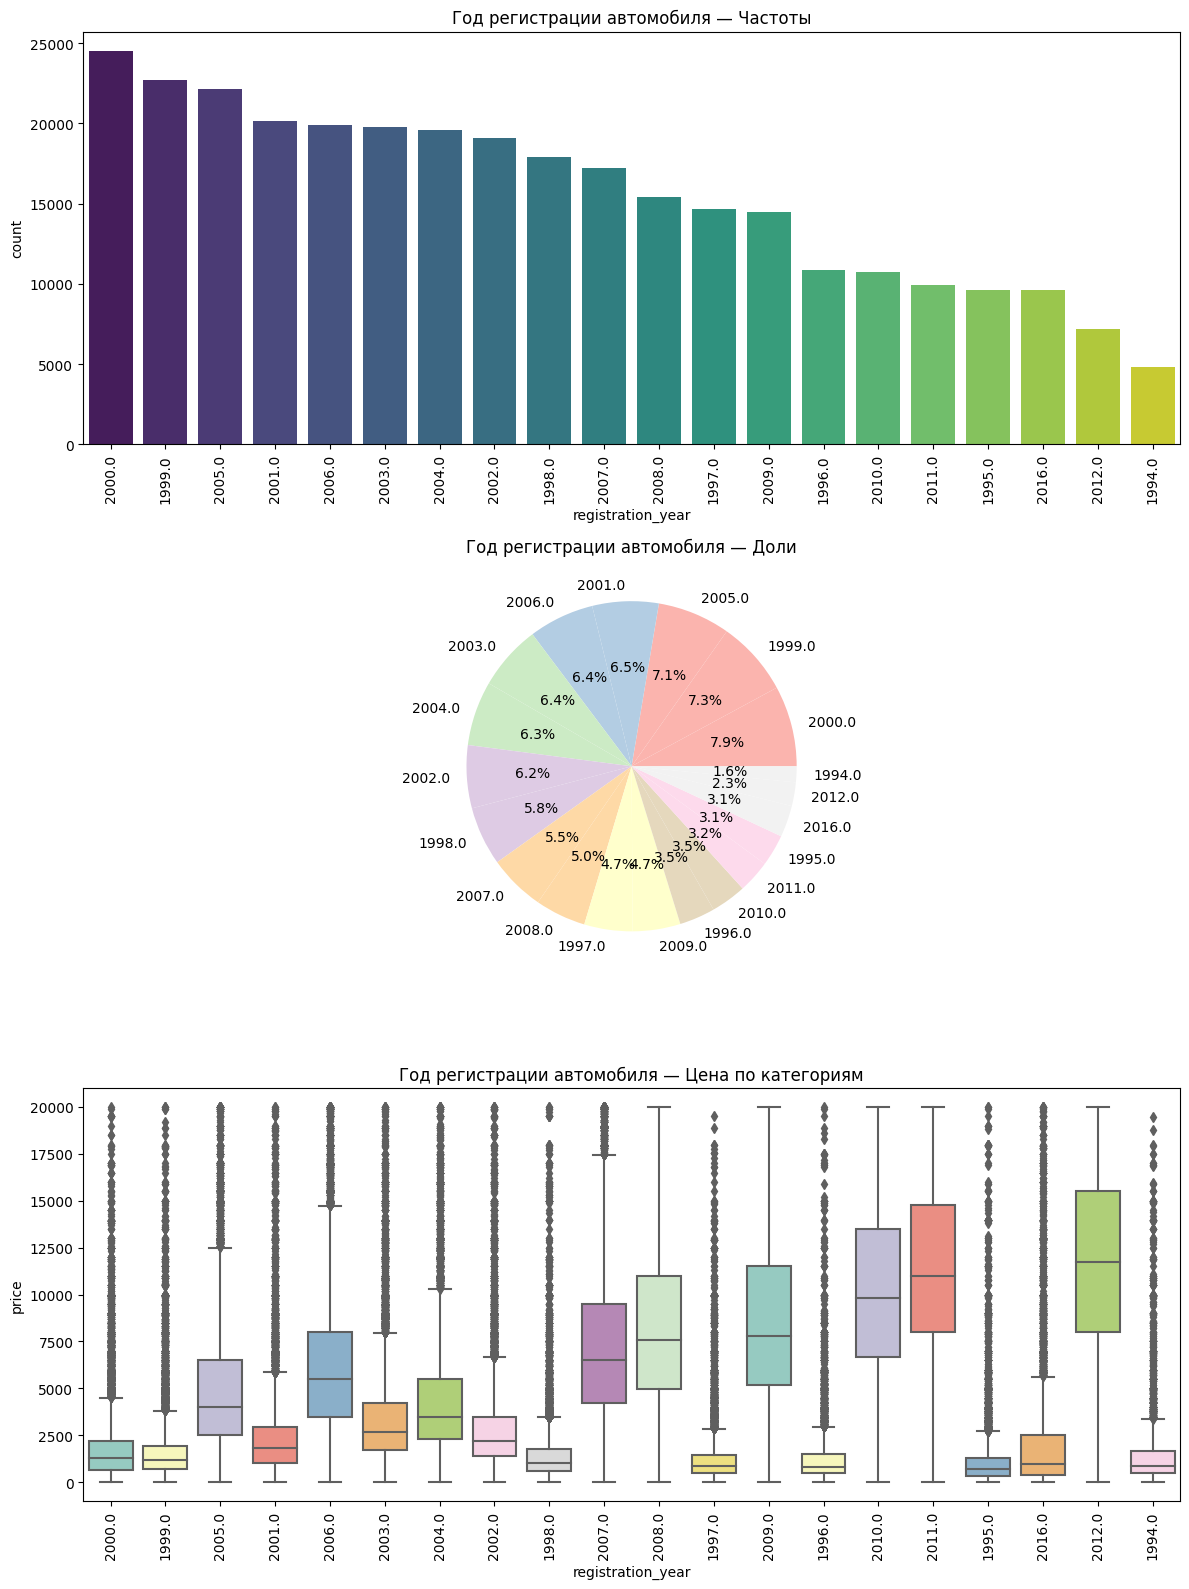

2,000.000    24490
1,999.000    22727
2,005.000    22109
2,001.000    20123
2,006.000    19900
2,003.000    19762
2,004.000    19611
2,002.000    19091
1,998.000    17899
2,007.000    17183
2,008.000    15391
1,997.000    14666
2,009.000    14503
1,996.000    10835
2,010.000    10764
2,011.000     9909
1,995.000     9607
2,016.000     9599
2,012.000     7178
1,994.000     4841
Name: registration_year, dtype: int64


In [37]:
categorical_features('registration_year', 'Год регистрации автомобиля', 20)

Больше всего продается автомобилей 2000, 1999, 2005 годов, хотя по цене они скорее относятся к низкому ценовому сегменту. Наиболее дорогие автомобили 2010-2012 годов.

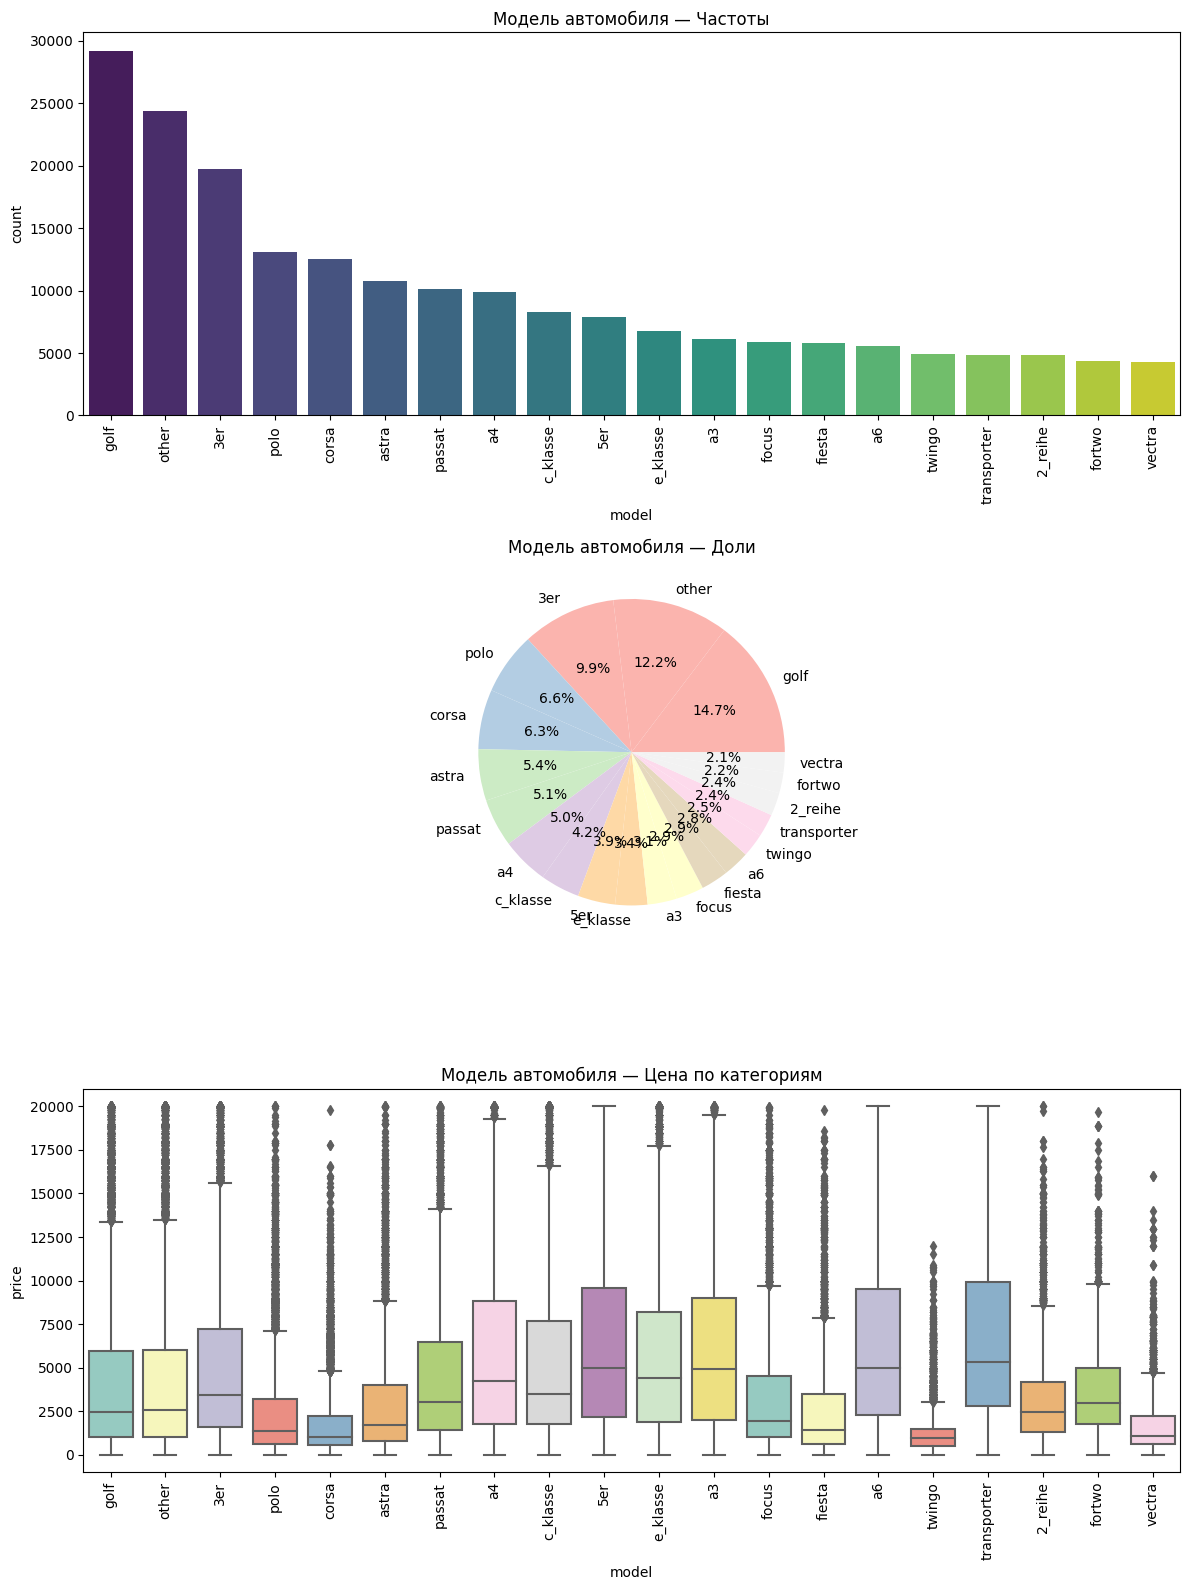

golf           29232
other          24420
3er            19761
polo           13066
corsa          12570
astra          10809
passat         10145
a4              9900
c_klasse        8312
5er             7868
e_klasse        6785
a3              6122
focus           5874
fiesta          5774
a6              5541
twingo          4953
transporter     4822
2_reihe         4816
fortwo          4337
vectra          4254
Name: model, dtype: int64


In [38]:
categorical_features('model', 'Модель автомобиля', 20)

Больше всего автомобилей модели гольф, других категорий и 3er их стоимость почти одинакова, в среднем от 2500 до 7000.   
Посмотрим на автомобили марки которых представлены в количесте менее 1000 штук.

In [39]:
model_counts = df['model'].value_counts()
rare_models = model_counts[model_counts < 300]
rare_models

sandero               295
roomster              276
carnival              273
xc_reihe              267
viano                 261
                     ... 
serie_2                 8
rangerover              4
serie_3                 4
serie_1                 2
range_rover_evoque      2
Name: model, Length: 103, dtype: int64

103 модели представлены в размере менее 300 штук. Объединим их в категорию `other`.

In [40]:
rare_models = rare_models.index
df['model'] = df['model'].apply(lambda x: 'other' if x in rare_models else x)

In [41]:
df['model'].nunique()

147

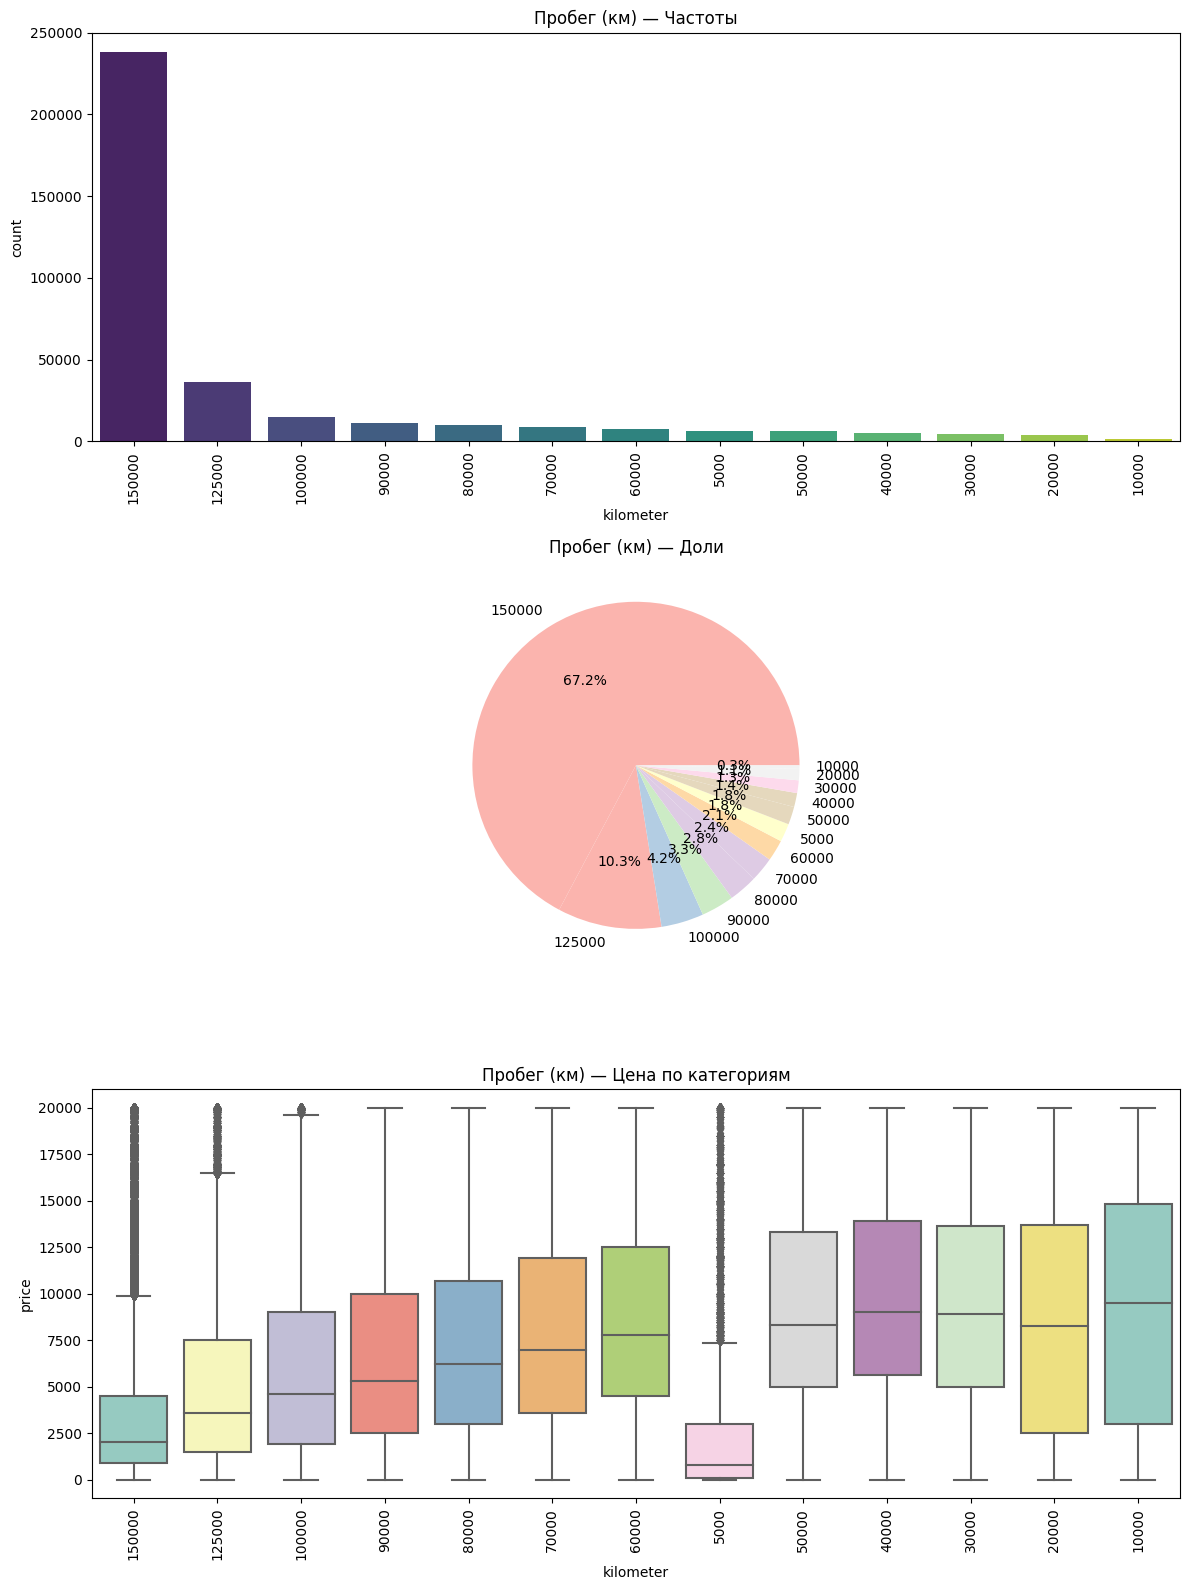

150000    238207
125000     36453
100000     14882
90000      11567
80000      10047
70000       8593
60000       7444
5000        6397
50000       6232
40000       4911
30000       4436
20000       3974
10000       1222
Name: kilometer, dtype: int64


In [42]:
categorical_features('kilometer', 'Пробег (км)', 20)

67% автомобилей имеет пробег 150000 км, 10% 125000, остальные автомобили имеют меньший пробег. Автомобили с пробегом 150000 км имеют почти самую низкую стоимостьв сравнении с остальными, за исключением автомобилей с пробегом 5000.

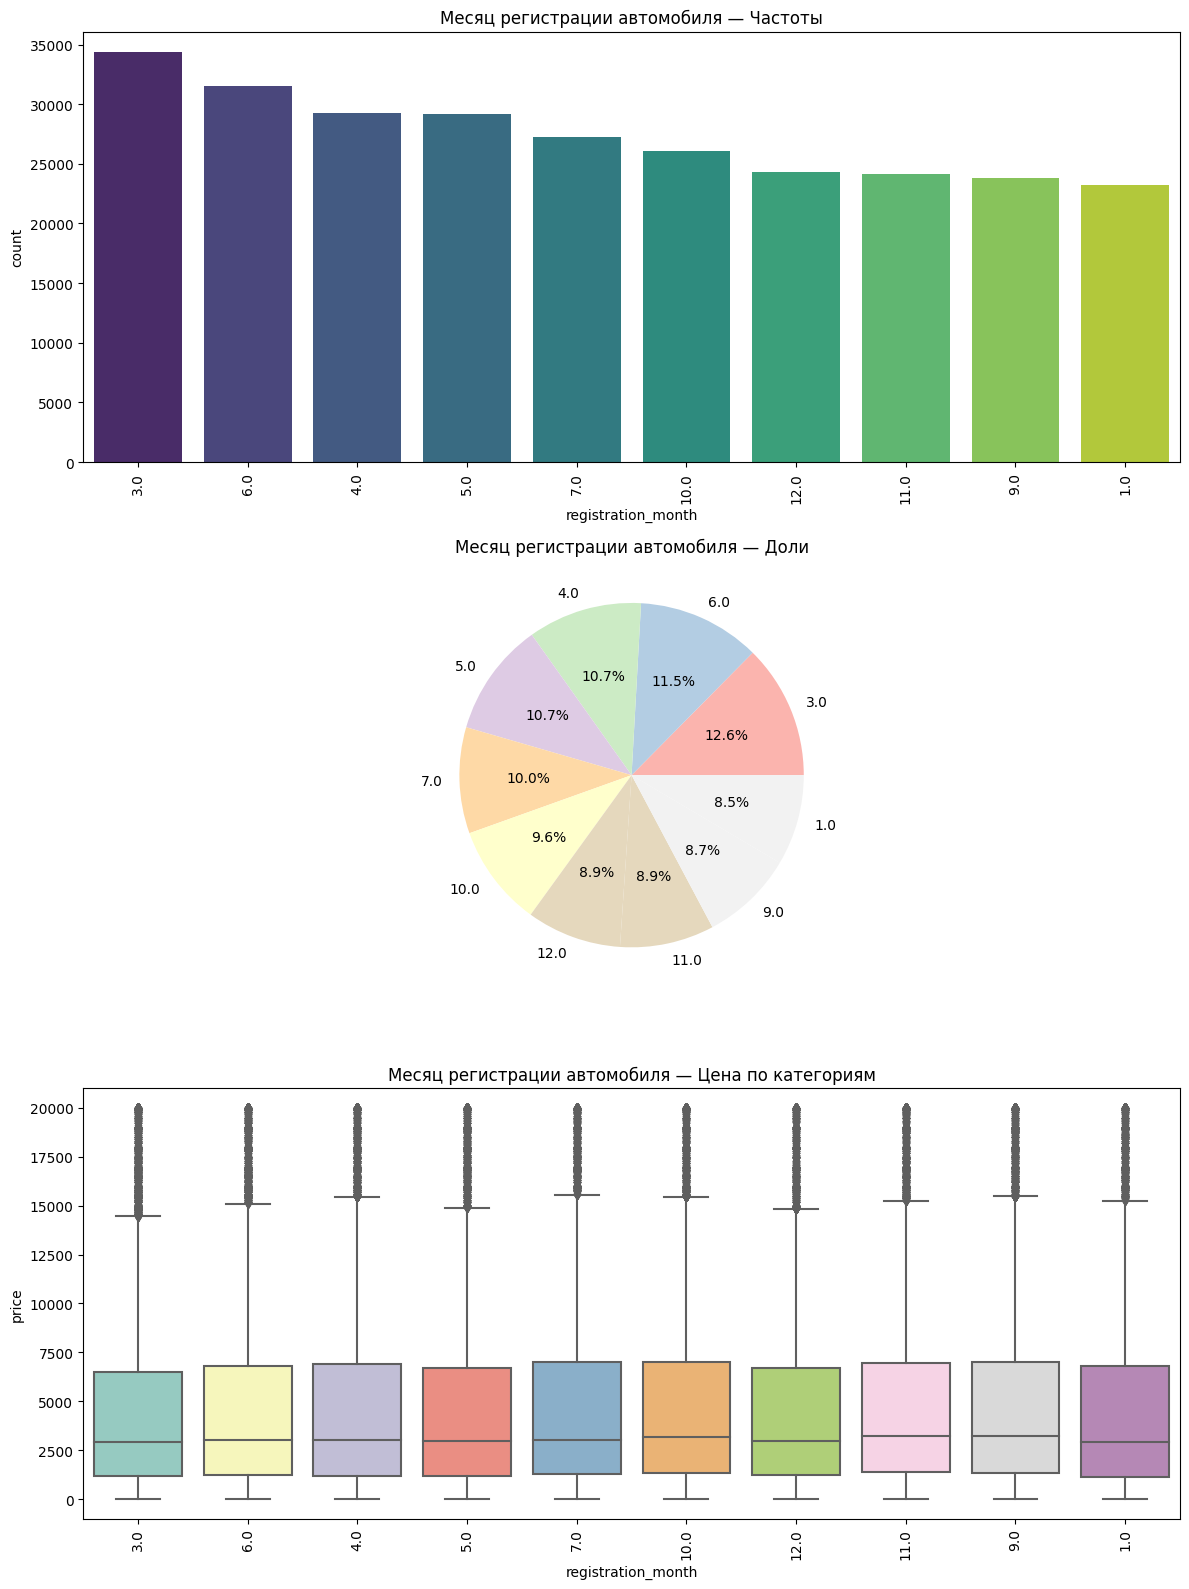

3.000     34373
6.000     31507
4.000     29270
5.000     29153
7.000     27211
10.000    26099
12.000    24289
11.000    24186
9.000     23813
1.000     23218
Name: registration_month, dtype: int64


In [43]:
categorical_features('registration_month', 'Месяц регистрации автомобиля')

Автомобили чаще всего регистрируют в марте и июне, реже всего в январе. Но вообще разница по количеству автомобилей и месяцам небольшая. Разницы в цене нет.

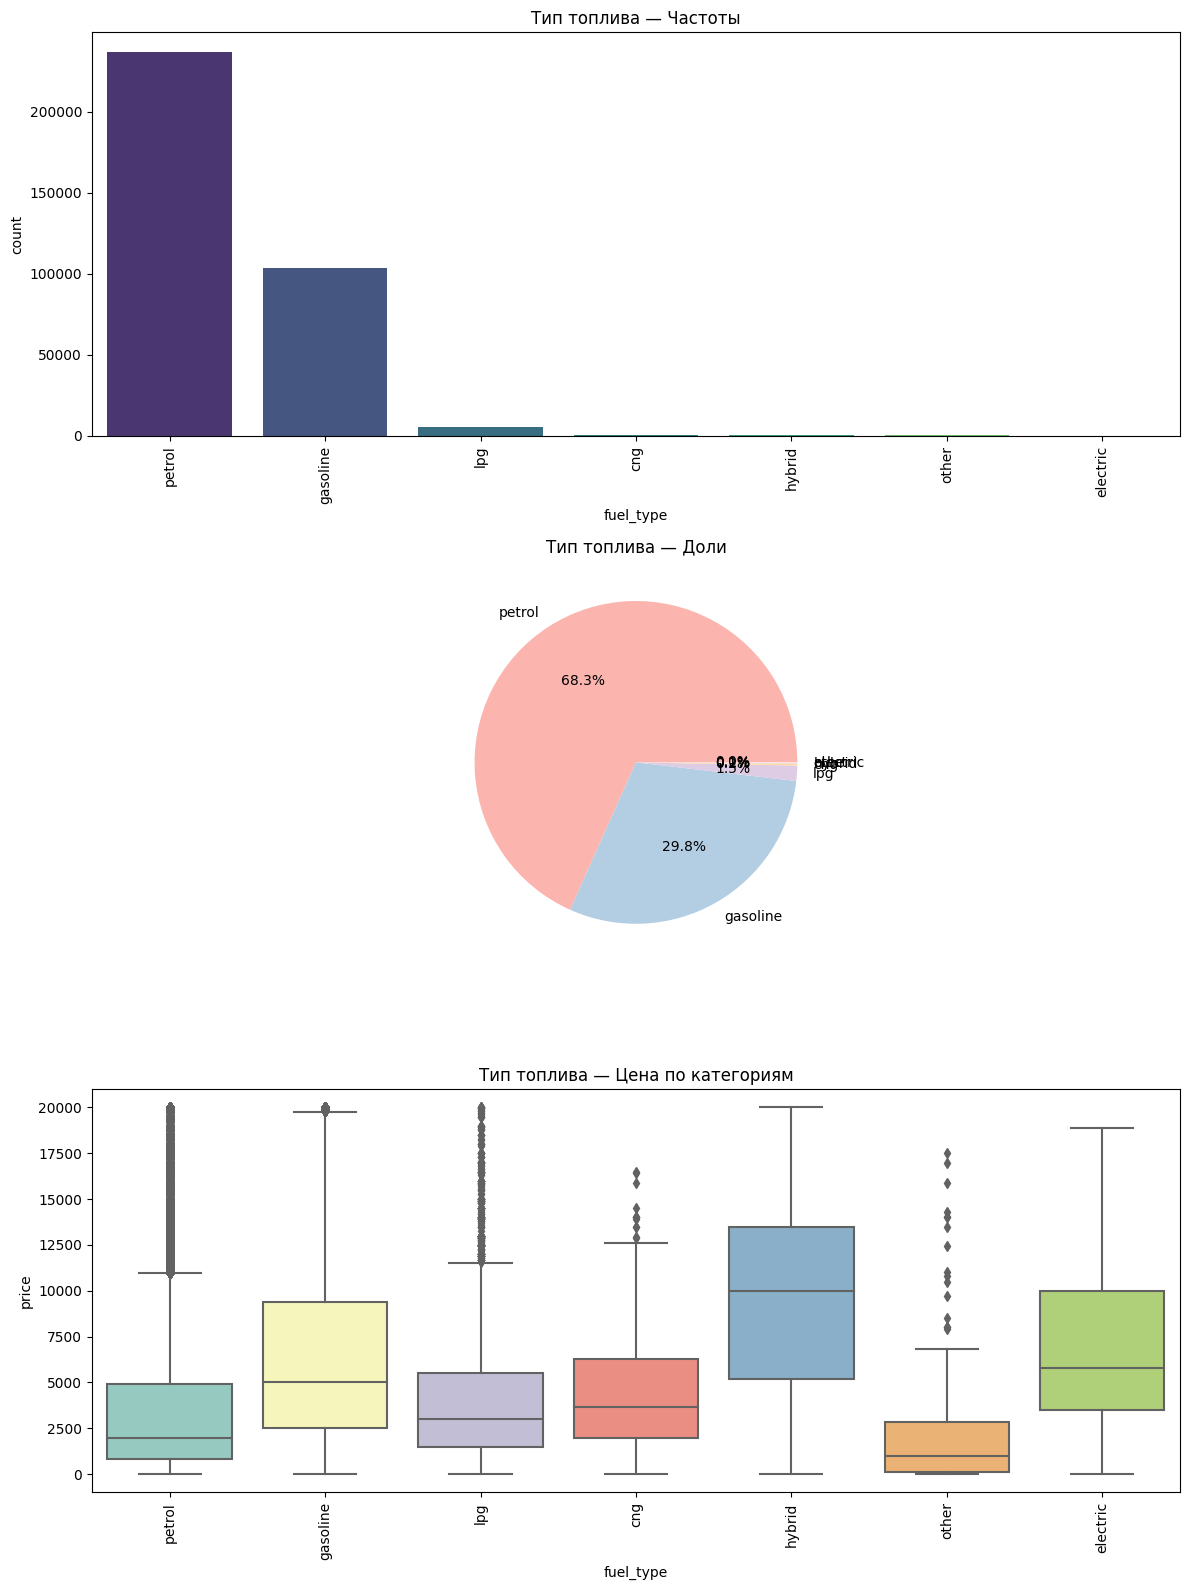

petrol      237182
gasoline    103618
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64


In [44]:
categorical_features('fuel_type', 'Тип топлива')

98% топлива - бензин (gasoline и petrol) имеют большой разброс в цене. Самые дорогие те, что предпочитают гибридное топливо. Второе по распространенности топливо - газовое. Объединим petrol и gasoline в одну категорию.

In [45]:
df['fuel_type'] = df['fuel_type'].replace({'petrol': 'gasoline'})
df['fuel_type'].value_counts()

gasoline    340800
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

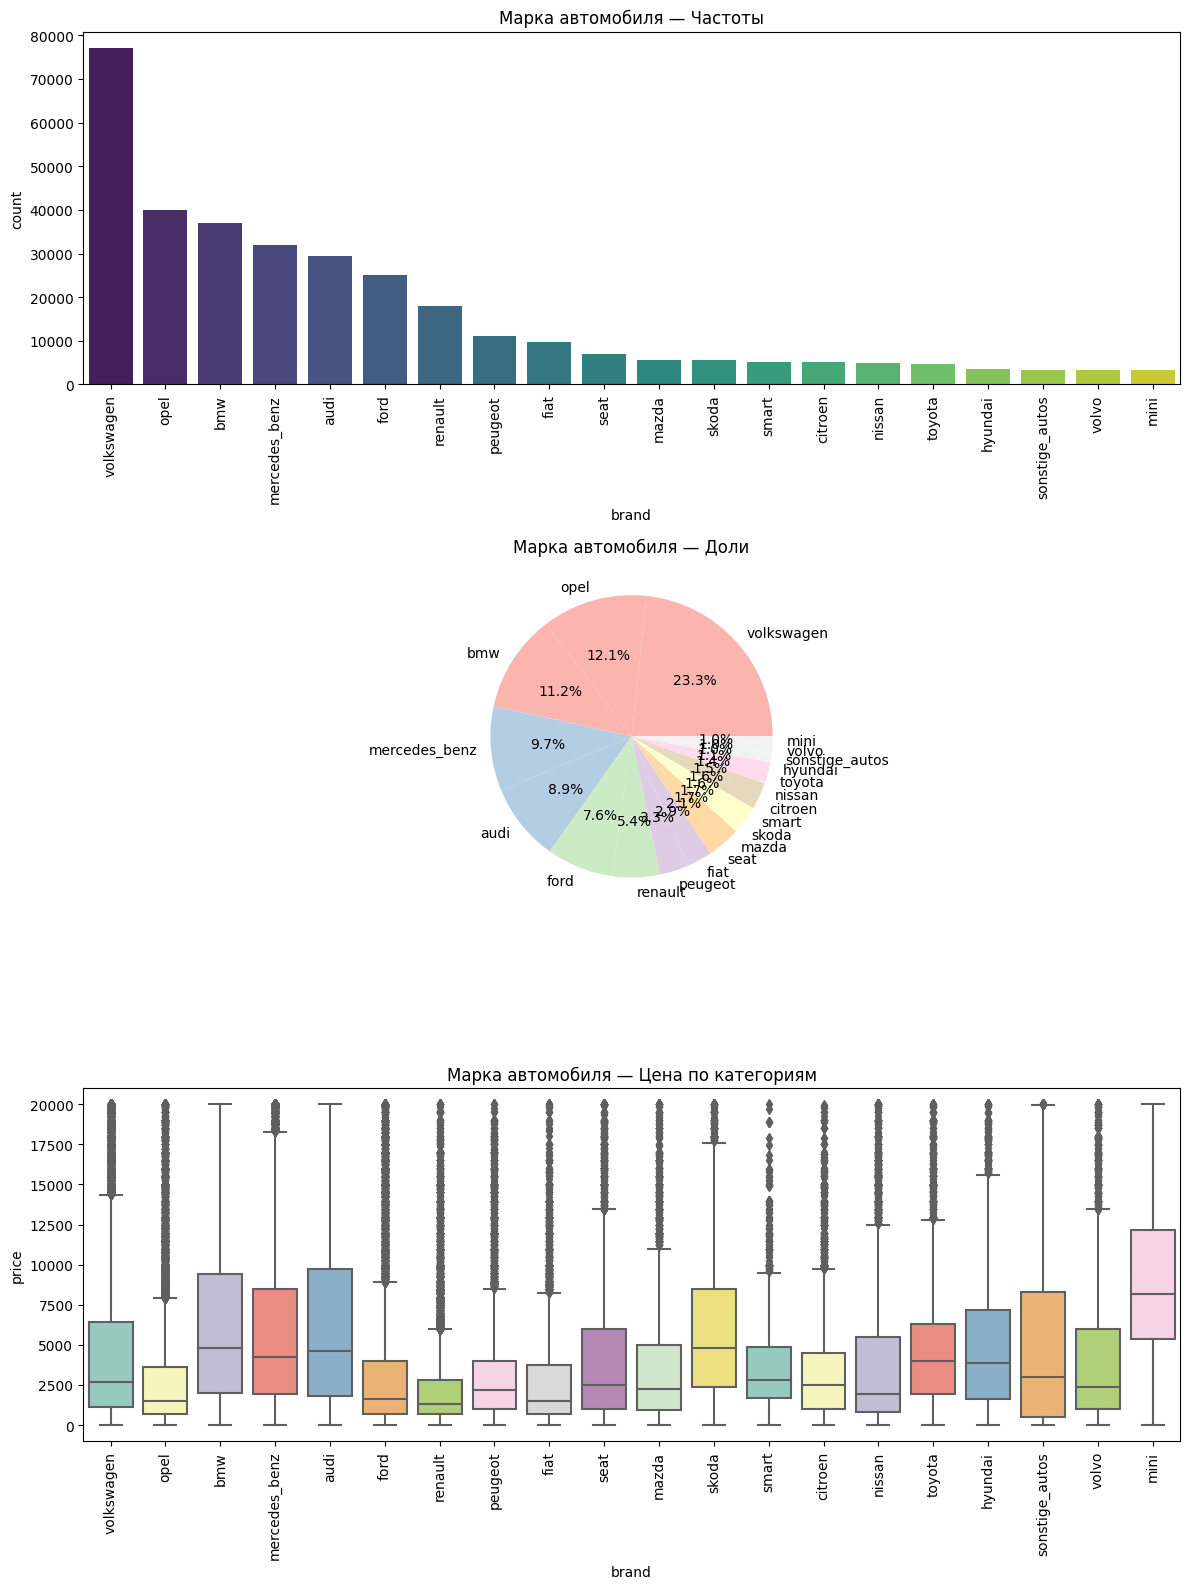

volkswagen        77012
opel              39931
bmw               36914
mercedes_benz     32044
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
Name: brand, dtype: int64


In [46]:
categorical_features('brand', 'Марка автомобиля', 20)

Более 70000 автомобилей марки volkswagen, на втором месте марки opel - чуть меньше 40000. Следующие по популярности bmw, mercedes_benz и audi, которые имеют больший разброс и максимум цены чем более популярные марки.   
Посмотрим на марки, автомобилей которых представлено в данных менее 1000 штук.

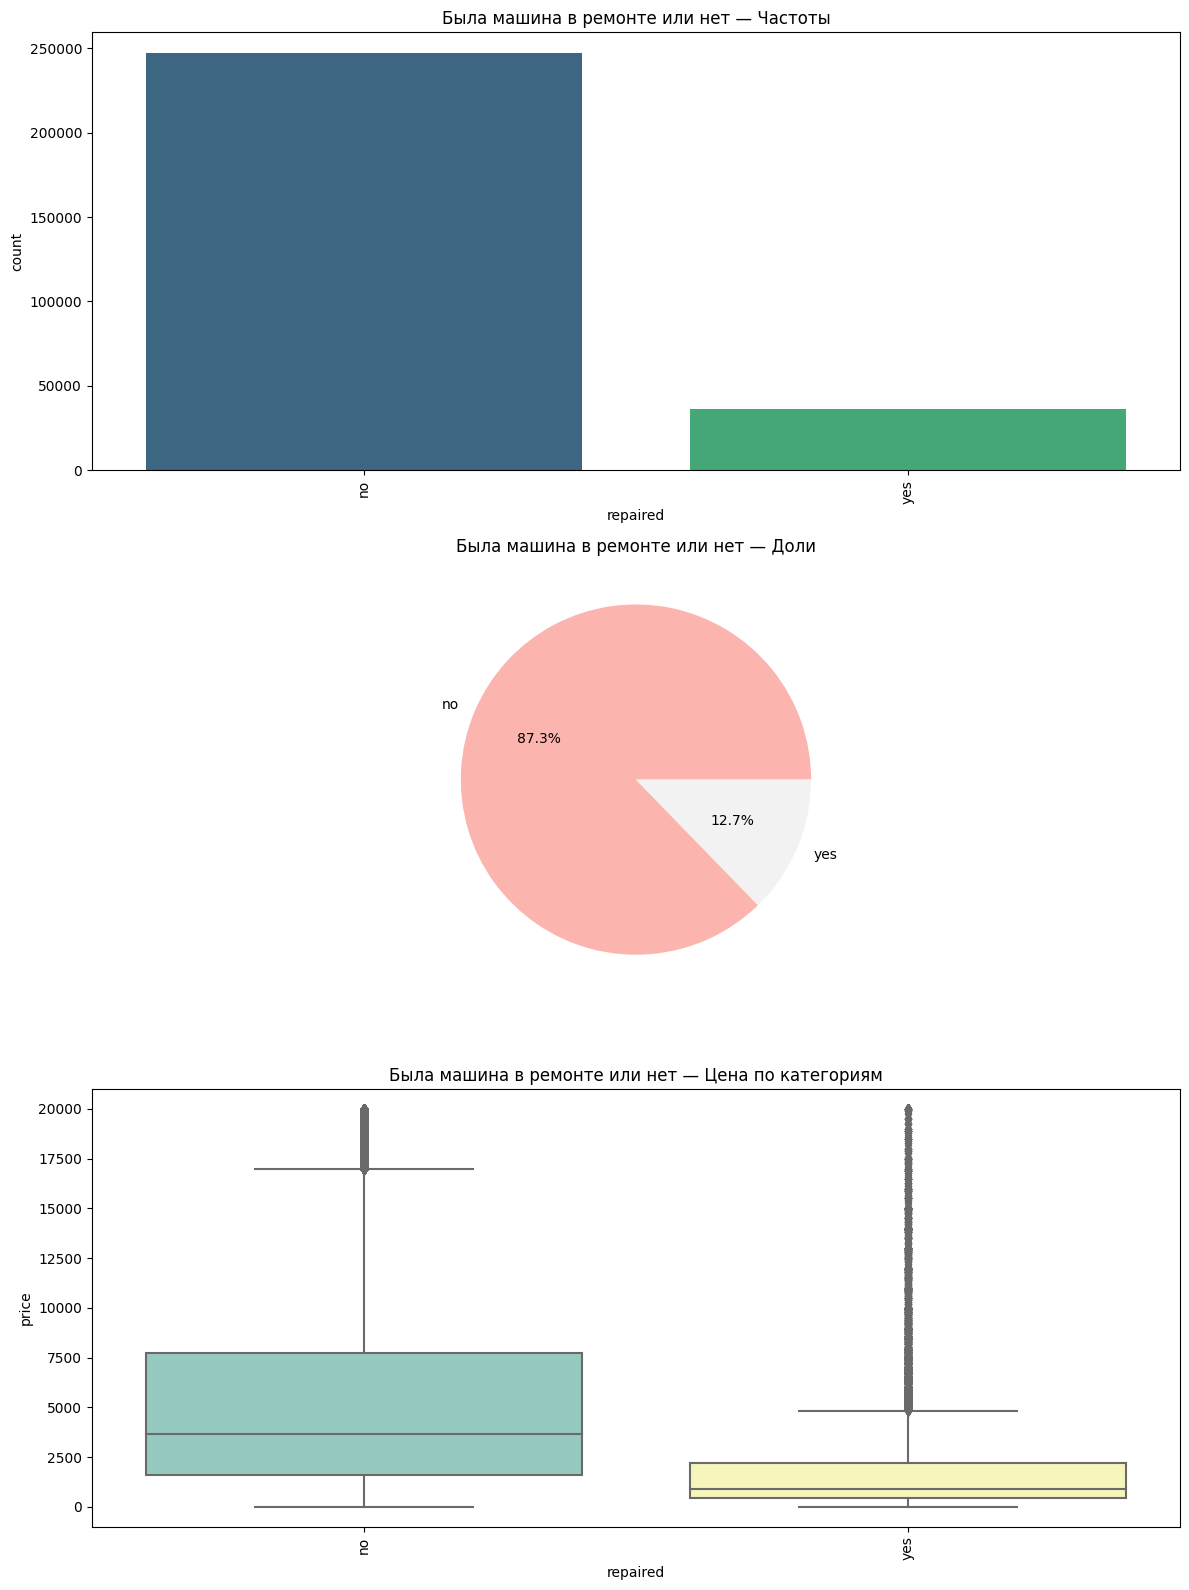

no     247158
yes     36053
Name: repaired, dtype: int64


In [47]:
categorical_features('repaired', 'Была машина в ремонте или нет')

87% машин не подвергались ремонту. Но держим в уме, что 68775 значений нам неизвестны. Позже примем решение о сохранении или удалении столбца.

In [48]:
def quantitative_features(attribute, title='', bins=20):
    """
    Визуализация количественного признака:
    - Если attribute == 'price': гистограмма и один boxplot
    - Иначе: гистограмма и boxplot по квантильным интервалам цены

    Параметры:
        df: DataFrame
        attribute: Название числового признака
        title: Заголовок графиков
        bins: Кол-во бинов в гистограмме
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))

    sns.histplot(df[attribute], kde=True, bins=bins, ax=ax[0], color='steelblue')
    ax[0].set_title(f'{title} - распределение', fontsize=14)
    ax[0].set_xlabel(attribute)
    ax[0].set_ylabel('Количество')

    if attribute == 'price':
        sns.boxplot(x=df[attribute], ax=ax[1], color='lightgreen')
        ax[1].set_title(f'{title} - boxplot', fontsize=14)
        ax[1].set_xlabel(attribute)
    else:
        df['price_bin'] = pd.qcut(df['price'], q=5, duplicates='drop')
        sns.boxplot(x='price_bin', y=attribute, data=df, palette='Pastel2', ax=ax[1])
        ax[1].set_title(f'{title} - по интервалам цены', fontsize=14)
        ax[1].set_xlabel('Интервалы цены')
        ax[1].tick_params(axis='x', rotation=45)
        df.drop(columns='price_bin', inplace=True)

    plt.tight_layout()
    plt.show()

    print(df[attribute].describe())

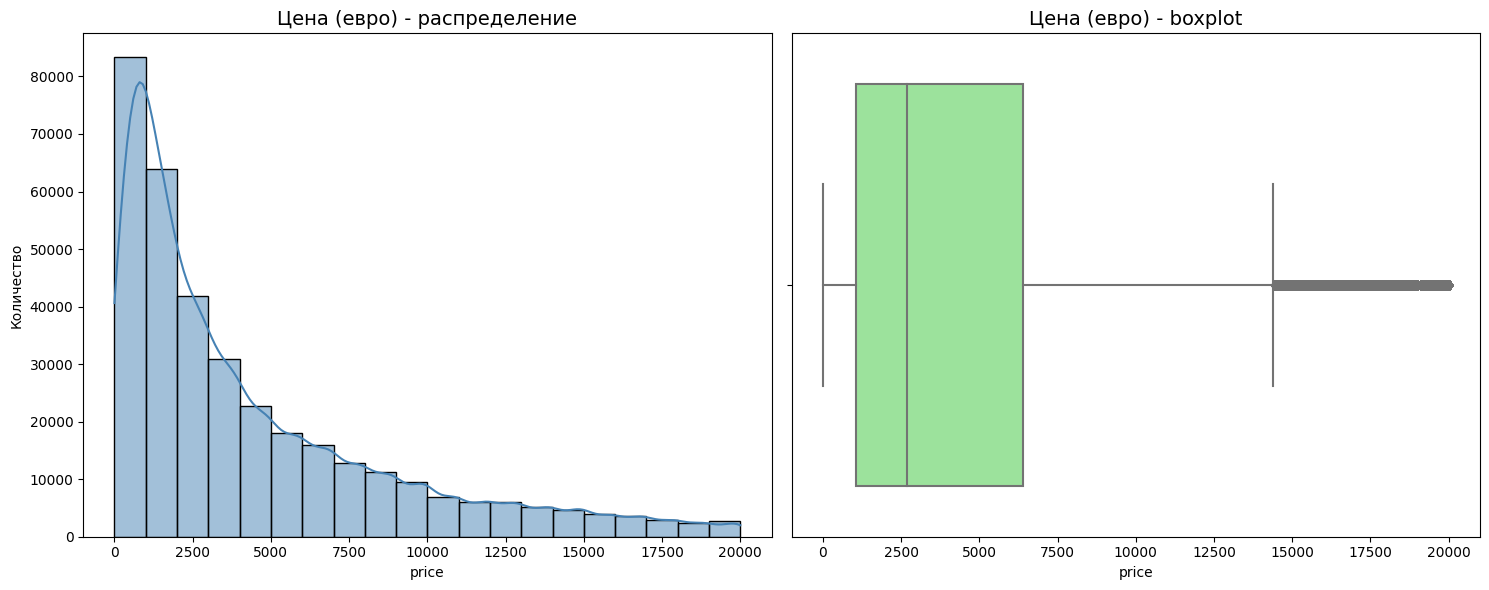

count   354,365.000
mean      4,416.680
std       4,514.176
min           0.000
25%       1,050.000
50%       2,700.000
75%       6,400.000
max      20,000.000
Name: price, dtype: float64


In [49]:
quantitative_features('price', 'Цена (евро)')

Большинство автомобилей стоят до 5000 евро, имеются так же автомобили, которые стоят дорого - свыше 10000 евро, но их мало. Вызывают сомнения автомобили стоимостью менее 200 евро и более 17500, удалим такие строки. Цены в 200 и 500 евро тоже нереалистичны, но судя по данным, это могут быть очень старые автомобили, которые продаются на запчасти и металлолом.

In [50]:
df = df.query('price > 200 and price < 17500')

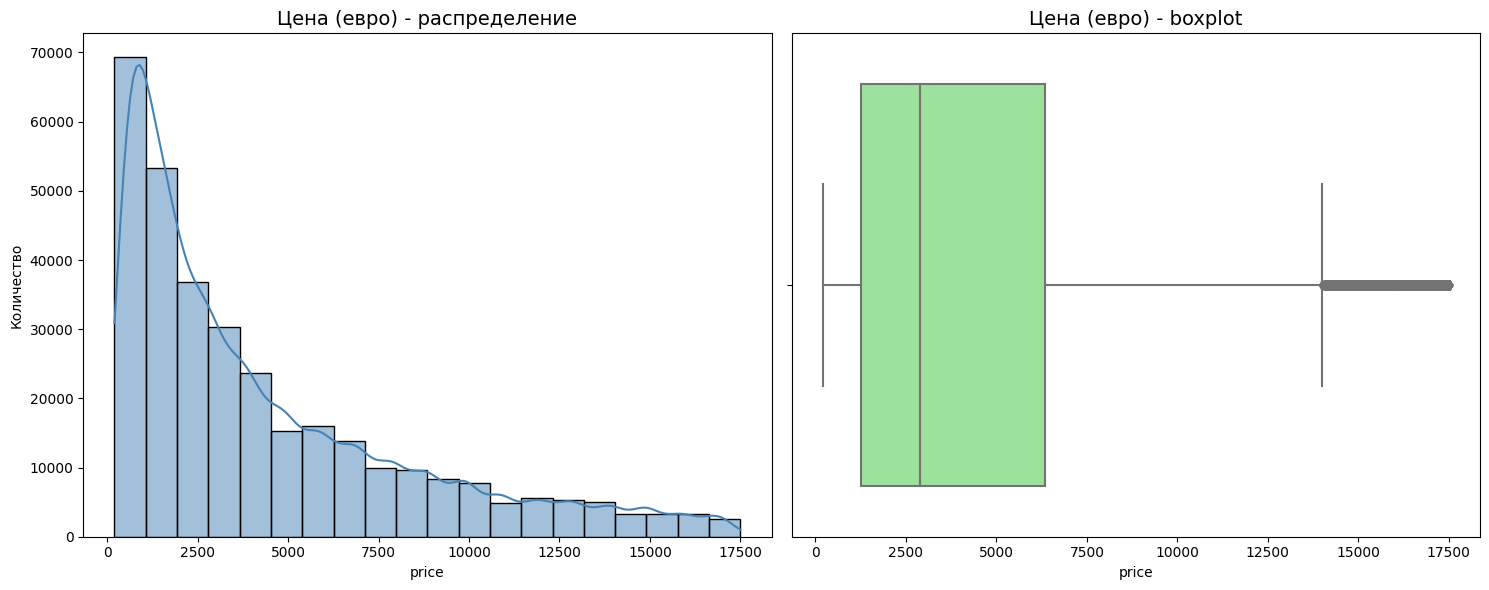

count   327,856.000
mean      4,366.259
std       4,054.631
min         202.000
25%       1,250.000
50%       2,900.000
75%       6,350.000
max      17,499.000
Name: price, dtype: float64


In [51]:
quantitative_features('price', 'Цена (евро)')

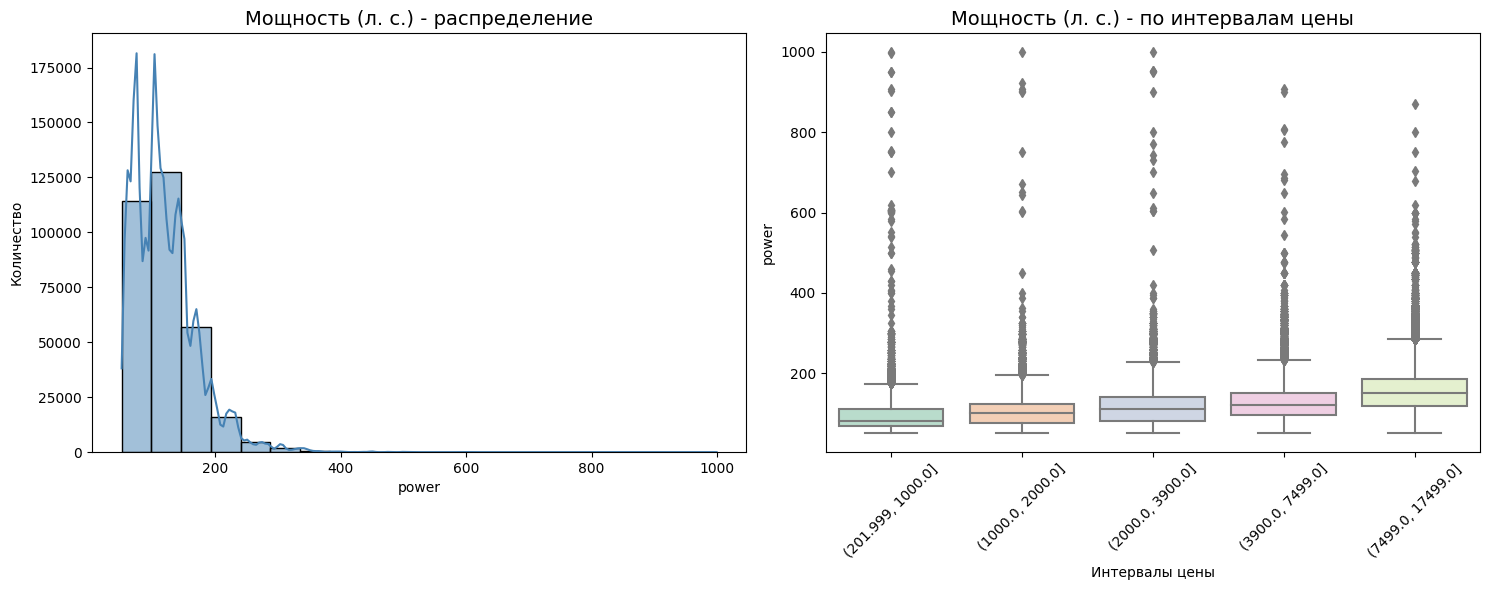

count   322,402.000
mean        119.950
std          51.086
min          51.000
25%          77.977
50%         110.000
75%         146.000
max         999.000
Name: power, dtype: float64


In [52]:
quantitative_features('power', 'Мощность (л. с.)')

Большинство автомобилей имеют мощность до 200 л.с. Чем выше мощность, тем выше цена. 
Срежем мощность еще раз, так как теперь видно, что мало автомобилей с мощностью более 400 л.с..

In [53]:
df = df.query('power < 300')

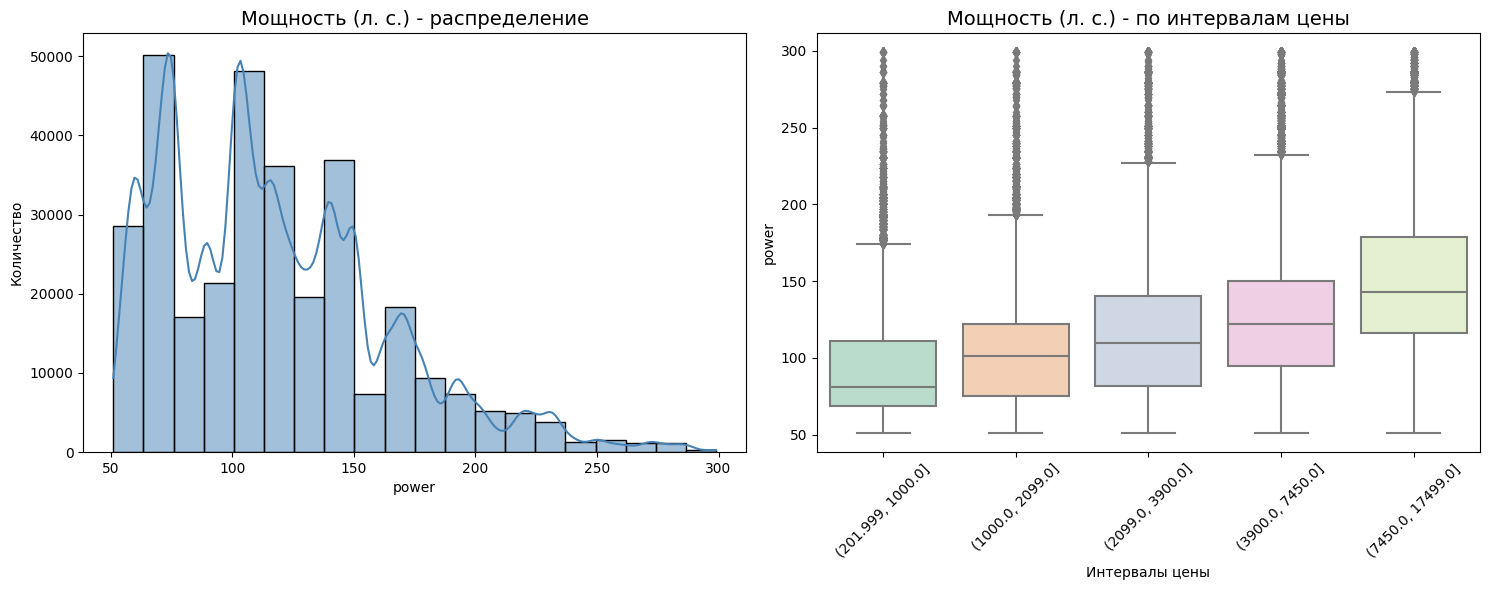

count   319,650.000
mean        117.962
std          45.947
min          51.000
25%          77.000
50%         110.000
75%         143.000
max         299.000
Name: power, dtype: float64


In [54]:
quantitative_features('power', 'Мощность (л. с.)')

In [55]:
def analyze_datetime_feature(date_column, time_unit='year', title=None):
    """
    Анализ и визуализация столбца с датами.
    """
    df_copy = df.copy()
    df_copy = df_copy.dropna(subset=[date_column])
    df_copy['year'] = df_copy[date_column].dt.year
    df_copy['month'] = df_copy[date_column].dt.month

    if time_unit == 'year':
        time_column = 'year'
    elif time_unit == 'month':
        time_column = 'month'
    else:
        raise ValueError("time_unit должен быть 'year' или 'month'")

    plt.figure(figsize=(10, 5))
    sns.histplot(df_copy[time_column], bins=len(df_copy[time_column].unique()), color='skyblue', edgecolor='black')
    
    plt.xlabel('Год' if time_unit == 'year' else 'Месяц')
    plt.ylabel('Количество записей')
    plt.title(title or f'Распределение по {time_unit}', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if time_unit == 'year':
        counts = df_copy.groupby(['year', 'month']).size().unstack().fillna(0)
        percentage = counts.div(counts.sum(axis=1), axis=0)

        percentage.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab20')
        plt.xlabel('Год')
        plt.ylabel('Доля записей')
        plt.title(f'{title or "Доля записей"} по месяцам', fontsize=14, fontweight='bold')
        plt.legend(title='Месяц', labels=[
            'Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
            'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'
        ], bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()


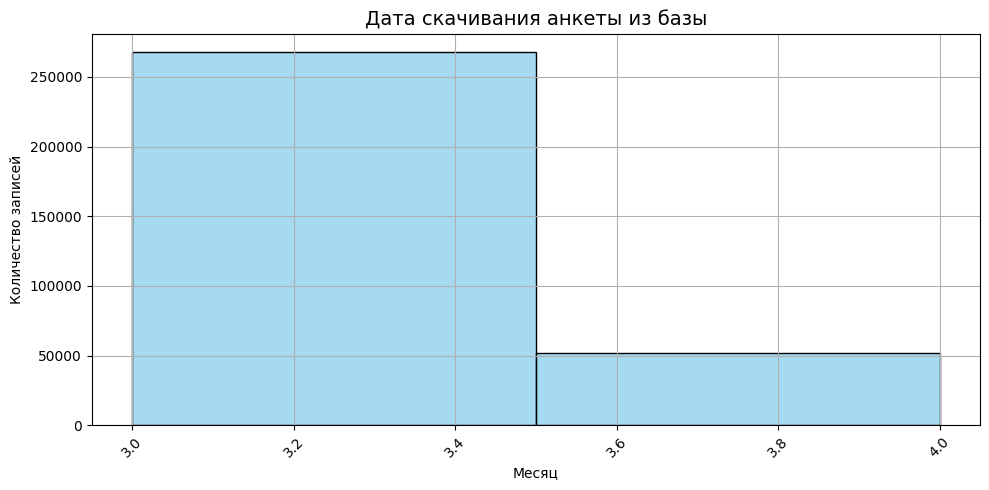

In [56]:
analyze_datetime_feature('date_crawled', 'month', 'Дата скачивания анкеты из базы')

Анкеты скачивали в течении марта 2016 года.

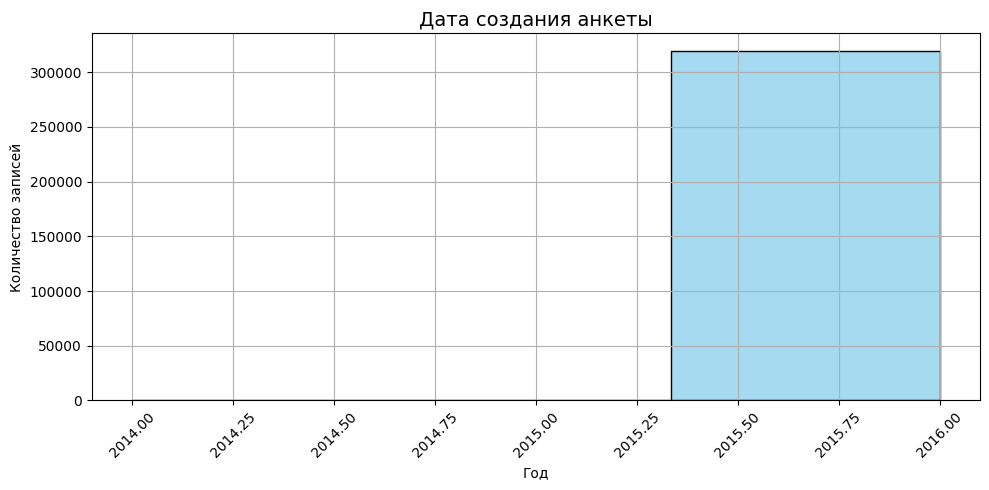

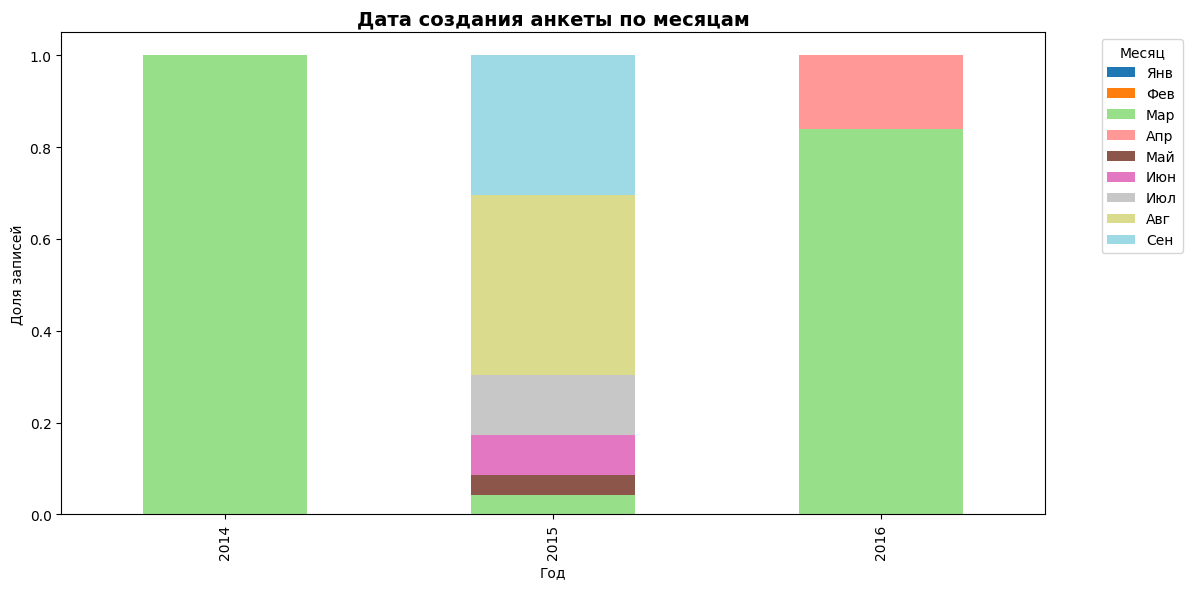

In [57]:
analyze_datetime_feature('date_created', 'year', 'Дата создания анкеты')

Анкеты были созданы с 2014 по 2016 год, в 2014 в марте, в 2016 - в марте и апреле, в 2015 наибольшее количество анкет было создано в августе и сентябре.

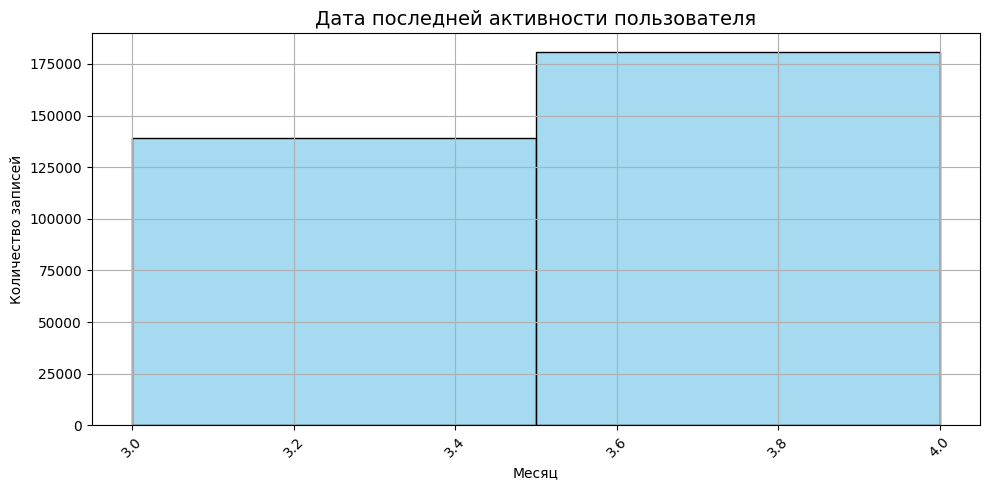

In [58]:
analyze_datetime_feature('last_seen', 'month', 'Дата последней активности пользователя')

Даты последних активностей пользователей совпадает с датой скачивания анкет из базы - соответсвенно можно сделать вывод, что это анкеты активных пользователей.

Исследуем зависимости между признаками.

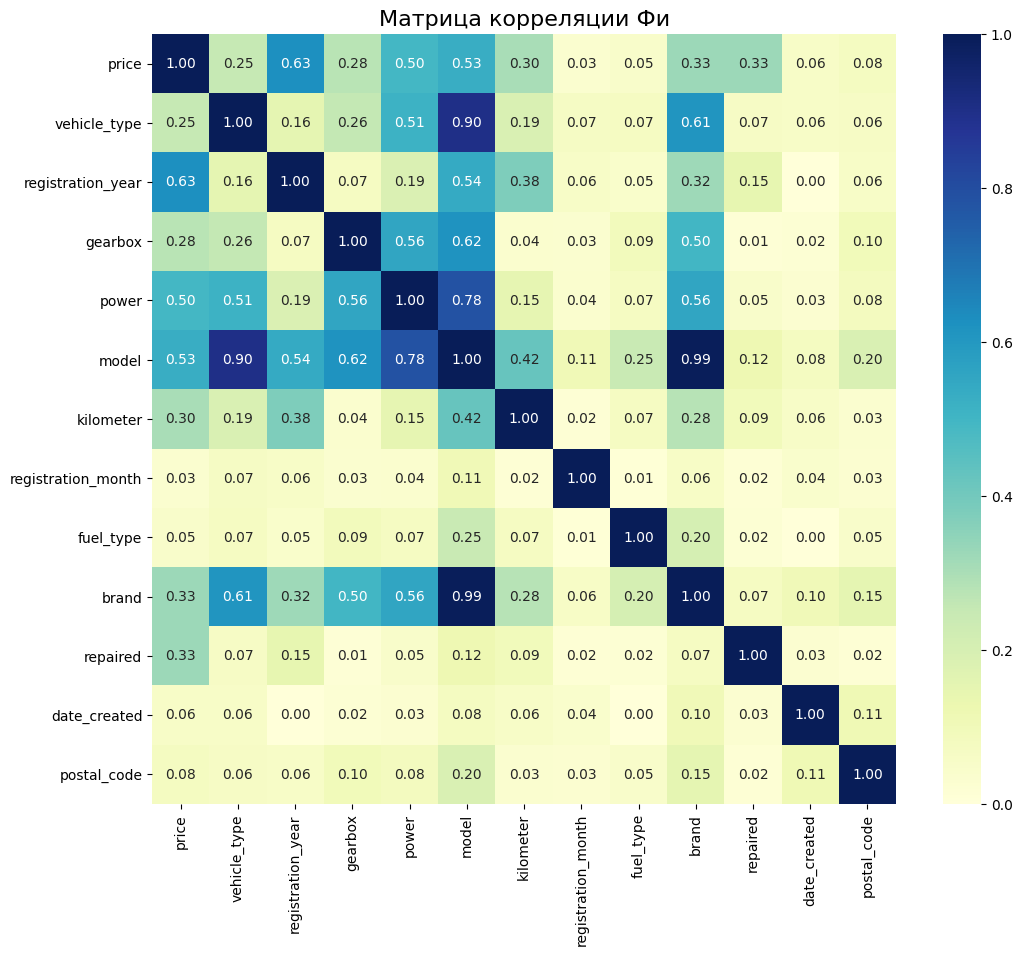

In [59]:
columns_to_drop = ['date_crawled', 'last_seen', 'number_of_pictures']
df_phik = df.drop(columns=columns_to_drop).dropna()

interval_cols = df_phik.select_dtypes(include=['number']).columns.tolist()
phik_overview = df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Удалим признаки `number_of_pictures`, `data_crowled`, `date_created`, `last_seen`, `postal_code`, `registration_month` так как они неинформативны. Так же удалим `vehicle_type`, `brand` так как они дают мультиколлинеарность, оставим признак `model` который хоть и содержит много уникальных значений, но зато имеет умеренную зависимость о целевого признка.

In [60]:
df = df.drop(['number_of_pictures', 'date_crawled', 'date_created', 'last_seen', 'postal_code', 'vehicle_type', 'brand', 'registration_month'], axis=1)

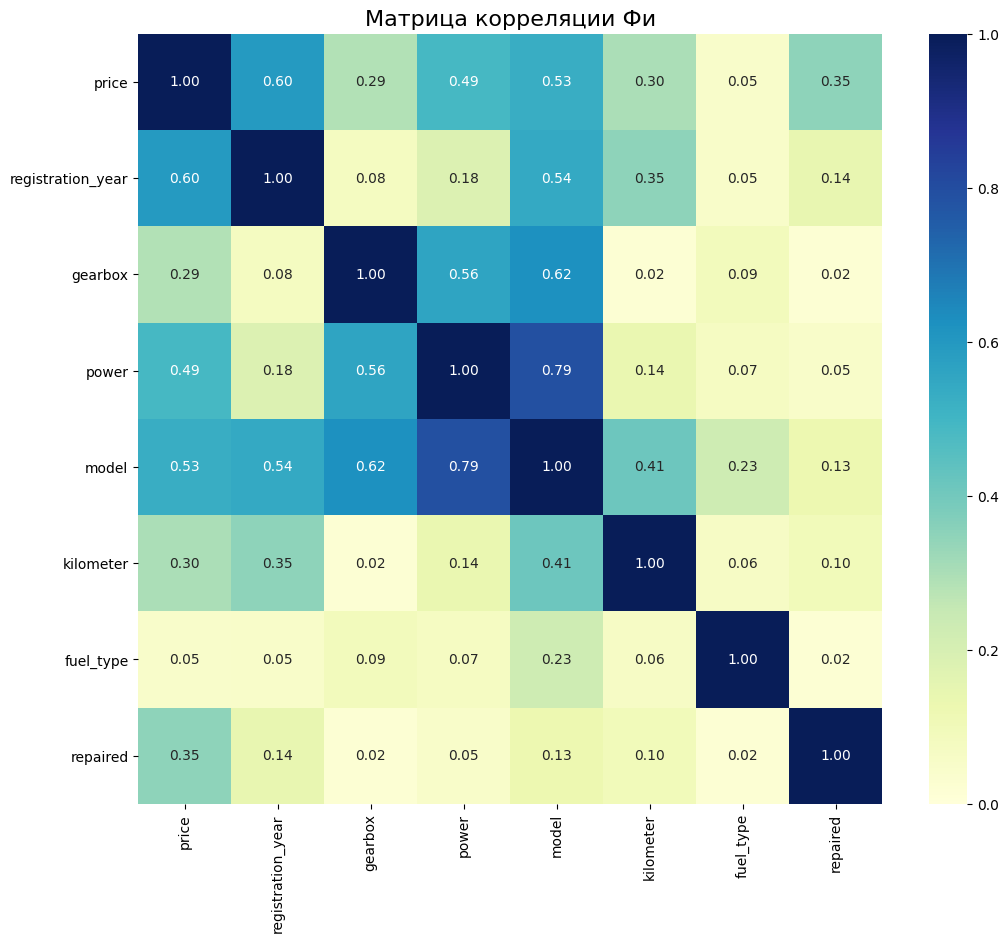

In [61]:
interval_cols = df.select_dtypes(include=['number']).columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10)) 
sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
plt.title('Матрица корреляции Фи', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Проверим на наличие дубликатов.

In [62]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 55854


In [63]:
df = df.drop_duplicates()

In [64]:
print(f'Количество выявленных явных дубликатов: {df.duplicated().sum()}')

Количество выявленных явных дубликатов: 0


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263796 entries, 0 to 354364
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              263796 non-null  int64  
 1   registration_year  252466 non-null  float64
 2   gearbox            263144 non-null  object 
 3   power              263796 non-null  float64
 4   model              253673 non-null  object 
 5   kilometer          263796 non-null  int64  
 6   fuel_type          260951 non-null  object 
 7   repaired           213871 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 18.1+ MB


### Промежуточный вывод
**Задача:** ознакомиться и подготовить данные.
1. Датасет загружен в `df`, имеет 354369 строк и 16 столбцов.
2. Исправлены типы данных у датированых признаков.
3. Удалены 4 дублирющиеся строки, изучвены уникальные типы данных, аномалии данных в столбцах `registration_year`, `registration_month` и `power` заменены на nan.
4. Заполнениы пропуски с столбцах `gear_box`, `fuel_type`, `power` значениями на основе значений модели и бренда. Урежены категории в столбце `model` и `fuel_type`.
5. Проведен исследовательский анализ данных, установлено, что типичное объявление содержит информацию об автомобиле 2000 года, зарегестрированного в марте, модель гольф, марка фольцваген, тип кузова седан, механическая коробка передач, пробег 150000 км, цена до 5000 евро, мощность 115 л.с., тип топлива бензин, машина не была в ремонте, дата послежней активности, дата скачивания анкеты 2016 и дата создания анкеты с 2014 по 2016 год.
6. Удалены строки со значением стоимости автомобиля менее 200 евро и более 15000, так же строки со значением мощности более 400 л.с..
7. Анализ коллинеарности выявил, что целевой признак умерено зависит от года регистрации и модели автомобиля.
8. Удалены неинформативные признаки и признаки вызывающие мультиколлинеарнось - number_of_pictures, data_crowled, date_created, last_seen, postal_code, vehicle_type, brand.
9. Финальный датасет содержит 263796 строк и 8 столбцов.

## Обучение моделей

Для обучения выбрано три модели: LGBMRegressor, CatBoost, RandomForestx. Подготовим выборки и закодируем признаки для каждой модели.

In [66]:
X = df.drop(columns='price')
y = df['price']

In [67]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = RANDOM_STATE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(158277, 7) (158277,)
(52760, 7) (52760,)
(52759, 7) (52759,)


Отлично, датасет разбит в соотношении 60/20/20.     

In [68]:
num_features = ['power','kilometer','registration_year']
cat_features = ['gearbox', 'model', 'fuel_type', 'repaired']

Заполним пропуски. Из числовых признаков имеются пропуски в столбце `registration_year` поэтому применим стратегию заполнения медианным значением.

In [69]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ]), num_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
        ('encoder', CatBoostEncoder())
    ]), cat_features)
])

preprocessor_cb = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
    ]), num_features),
    
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='unknown'))
    ]), cat_features)
])

In [70]:
X_train_all = preprocessor.fit_transform(X_train, y_train)
X_valid_all = preprocessor.transform(X_valid)

X_train_cb = preprocessor_cb.fit_transform(X_train, y_train)
X_valid_cb = preprocessor_cb.transform(X_valid)

X_train_cb_df = pd.DataFrame(X_train_cb, columns=['power', 'kilometer', 'registration_year', 'gearbox', 'model', 'fuel_type', 'repaired'])
X_valid_cb_df = pd.DataFrame(X_valid_cb, columns=['power', 'kilometer', 'registration_year', 'gearbox', 'model', 'fuel_type', 'repaired'])

for col in cat_features:
    X_train_cb_df[col] = X_train_cb_df[col].astype(str)
    X_valid_cb_df[col] = X_valid_cb_df[col].astype(str)

Обучим модели и подберем гиперпараметры.

In [71]:
def tune_model(model_class, param_grid, X_tr, y_tr, X_val, y_val, cat_features=None):
    """
    Функция для тюнинга гиперпараметров модели с использованием GridSearchCV и оценки по RMSE.
    
    Parameters:
    - model_class: Класс модели 
    - param_grid: Словарь с гиперпараметрами 
    - X_tr: Данные для обучения
    - y_tr: Целевая переменная для обучения
    - X_val: Данные для валидации
    - y_val: Целевая переменная для валидации
    - cat_features: Список категориальных признаков
    
    Returns:
    - result: Словарь с результатами поиска, лучшими параметрами и оценкой модели
    """
    
    grid_search = GridSearchCV(
        estimator=model_class(),
        param_grid=param_grid,
        cv=3,
        scoring='neg_mean_squared_error',
        n_jobs=-1)
    
    start_fit = time.time()

    if model_class == CatBoostRegressor:
        grid_search.fit(X_tr, y_tr, cat_features=cat_features)
    else:
        grid_search.fit(X_tr, y_tr)
        
    fit_time = time.time() - start_fit
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    start_pred = time.time()
    y_pred = best_model.predict(X_val)
    pred_time = time.time() - start_pred

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    result = {
        'model': model_class.__name__,
        'params': best_params,
        'rmse': round(rmse, 2),
        'fit_time': round(fit_time, 2),
        'pred_time': round(pred_time, 2),
        'model_obj': best_model
    }

    return result

In [72]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [8, 12],
    'n_jobs': [-1]
}

lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'n_jobs': [-1]
}

catboost_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'verbose': [False]
}

results = []

In [73]:
%%time
rf_result = tune_model(RandomForestRegressor, rf_param_grid, X_train_all, y_train, X_valid_all, y_valid)
results.append(rf_result)

lgbm_result = tune_model(LGBMRegressor, lgbm_param_grid, X_train_all, y_train, X_valid_all, y_valid)
results.append(lgbm_result)

catboost_result = tune_model(CatBoostRegressor, catboost_param_grid, X_train_cb_df, y_train, X_valid_cb_df, y_valid, cat_features=cat_features)
results.append(catboost_result)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1325
[LightGBM] [Info] Number of data points in the train set: 158277, number of used features: 7
[LightGBM] [Info] Start training from score 4493.777409
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1323
[LightGBM] [Info] Number of data points in the train set: 105518, number of used features: 7
[LightGBM] [Info] Start training from score 4495.535672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] To

### Промежуточный вывод

**Задача:** Подготовить выборки и обучить модели.
1. Подготовлено три выборки: тренировочная, валидационная и тестовая.
2. Определены категориальные и количественные признаки.
3. Подготовлен препроцессор который позволит заполнить пропуски в данных и закодирует категориальные признаки CatBoostEncoder.
4. Для обучения использованы три модели: LGBMRegressor, CatBoost, RandomForest с подбором гиперпараметров.
5. Время обучения всех трех моделей с подбором гиперпараметров и получением пресказания на валидационной выборке с расчетом метрики заняло 2 минуты 52 секунд.

## Анализ моделей

In [77]:
results_df = pd.DataFrame(results)
results_df = results_df.drop('model_obj', axis=1)
pd.set_option('display.max_colwidth', None)
results_df

,model,params,rmse,fit_time,pred_time
0,RandomForestRegressor,"{'max_depth': 12, 'n_estimators': 100, 'n_jobs': -1}","1,803.220",85.750,0.160
1,LGBMRegressor,"{'learning_rate': 0.1, 'n_estimators': 200, 'n_jobs': -1}","1,747.790",18.940,0.130
2,CatBoostRegressor,"{'iterations': 200, 'learning_rate': 0.1, 'verbose': False}","1,768.300",42.330,0.080


Лучшая модель LGBMRegressor со значением метрики RMSE 1747.790, временем обучения 29.190, временем предсказания 0.190.

In [75]:
best_model_info = min(results, key=lambda x: x['rmse'])
best_model = best_model_info['model_obj']
best_params = best_model_info['params']

Получим предсказание на тестовых данных.

In [76]:
X_test_processed = preprocessor.transform(X_test)
y_pred_test = best_model.predict(X_test_processed)
test_rmse = mean_squared_error(y_test, y_pred_test, squared = False)

print(f"Лучшая модель: {best_model.__class__.__name__}")
print(f"Параметры: {best_params}")
print(f"RMSE на тестовых данных: {test_rmse:.2f}")

Лучшая модель: LGBMRegressor
Параметры: {'learning_rate': 0.1, 'n_estimators': 200, 'n_jobs': -1}
RMSE на тестовых данных: 1747.57


### Промежуточный вывод

**Задача:** Проанализировать модели и выбрать лучшую.
1. Все модели дали метрику менее 2500, но по времени обучения, предсказания лидирует модель LightGBM.
2. Определена лучшая модель LGBMRegressor c параметрами: количество деревьев 200, коэффициент обучения 0.1, время обучения 29.190, время предсказания 0.190, метрика RMSE 1747.79.
3. На тестовой выборке метрика RMSE равна 1747.57.

# Общий вывод

Целью проекта было разработать модель машинного обучения для предсказания рыночной стоимости автомобилей на основе их технических характеристик и комплектации. В рамках работы были выполнены следующие этапы:

**Подготовка данных:**

- Датасет состоял из 354,369 строк и 16 столбцов. Были выполнены следующие действия:
   * Исправлены типы данных для датированных признаков.
   * Удалены дублирующиеся строки.
   * Применены корректировки для аномальных данных в столбцах (например, в столбцах с годом регистрации, месяцем регистрации и мощностью).
   * Проведен исследовательский анализ данных, что позволило выявить типичные характеристики автомобилей и отклонения в данных.
   * Были удалены строки с стоимостью ниже 200 евро.
   * Применен анализ коллинеарности, в результате которого были удалены неинформативные и сильно коррелирующие признаки.
   * Финальный датасет содержит 263,796 строк и 8 столбцов.

**Подготовка выборок и обучение моделей:**
- Подготовлены три выборки: тренировочная, валидационная и тестовая.
- Определены категориальные и количественные признаки, подготовлен препроцессор для их обработки (заполнение пропусков и кодирование категориальных признаков с помощью CatBoostEncoder).
- Для обучения использовались три модели: LGBMRegressor, CatBoost и RandomForest. Также был проведен подбор гиперпараметров. 
- Общее время обучения всех моделей, включая подбор гиперпараметров и вычисление метрик, составило 4 минуты 50 секунд.

**Анализ моделей и выбор лучшей:**

- Все модели показали результат с метрикой RMSE менее 2500, однако LGBMRegressor продемонстрировал наилучший результат по времени обучения и предсказания. 
- Лучшей моделью была выбрана LGBMRegressor с гиперпараметрами:
    * Количество деревьев (n_estimators): 200
    * Коэффициент обучения (learning_rate): 0.1
    * Время обучения: 29.190 секунд
    * Время предсказания: 0.190 секунд
    * Метрика RMSE на валидационной выборке: 1747.79

- На тестовой выборке метрика RMSE составила 1747.57, что подтверждает хорошую обобщающую способность модели.

**Заключение:**
Модель LGBMRegressor продемонстрировала наилучший баланс между качеством предсказаний и временем обучения/предсказания. Она обеспечила высокую точность предсказания рыночной стоимости автомобилей при минимальных вычислительных затратах, что соответствует требованиям заказчика по скорости работы приложения.